In [7]:
import scanpy as sc
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import scib
import os
import matplotlib.pyplot as plt
import harmony
import pertpy as pt

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

Extension horovod.torch has not been built: /usr/local/lib/python3.10/dist-packages/horovod/torch/mpi_lib_v2.cpython-310-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still available.


Global seed set to 0
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

To use sccoda or tasccoda please install ete3 with pip install ete3

In [13]:
import rpy2.robjects.packages as rpackages
from rpy2.robjects import r

utils = rpackages.importr('utils')
utils.install_packages('kBET')

kbet = rpackages.importr('kBET')

R[write to console]: Installing package into ‘/home/mahim/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)



# Batch correction: RxRx19b, HUVEC

For more information on the dataset please see: https://www.rxrx.ai/rxrx19b and https://github.com/theislab/batch_correction_cellpainting/blob/feat/rxrx1_huvec_exploration/data/rxrx19b/rxrx19b_overview.md <br>

* [I. Before integration](#before)
    * [A. Read in the data and identify the batch_key](#before_sub1)
    * [B. Find which metrics are applicable for this dataset](#before_sub2)
    * [C. Compute scIB metrics](#before_sub3)
* [II. Integration](#integrate)
    * [A. Harmony](#integrate_sub1)
    * [B. Scanorama](#integrate_sub2)
    * [C. scVI](#integrate_sub3)
    * [D. scanVI](#integrate_sub4)
    * [E. scGen](#integrate_sub5)
* [III. After integration](#after)
    * [A. Harmony: Compute scIB metrics](#after_sub1)
    * [B. Harmony: Before and after UMAP visualization](#after_sub2) 
    * [C. Scanorama: Compute scIB metrics](#after_sub3)
    * [D. Scanorama: Before and after UMAP visualization](#after_sub4)
    * [E. scVI: Compute scIB metrics](#after_sub5)
    * [F. scVI: Before and after UMAP visualization](#after_sub6)
    * [G. scanVI: Compute scIB metrics](#after_sub7)
    * [H. scanVI: Before and after UMAP visualization](#after_sub8)
    * [I. scGen: Compute scIB metrics](#after_sub9)
    * [J. scGen: Before and after UMAP visualization](#after_sub10)
    

## I. Before integration  <a class="anchor" id="before"></a>

### A. Read in the data and identify the batch_key<a class="anchor" id="before_sub1"></a>

Read in the embeddings and add metadata to adata.obs:

In [2]:
meta_file = "../../data/rxrx19b/metadata.csv"
embedding_file = "../../data/rxrx19b/embeddings.csv"
if not os.path.exists(meta_file):
    raise FileNotFoundError("Please download the metadata from https://www.rxrx.ai/rxrx19b and put the file metadata.csv in the directory data/rxrx19b")
if not os.path.exists(embedding_file):
    raise FileNotFoundError("Please download the embeddings from https://www.rxrx.ai/rxrx19b and put the file embeddings.csv in the directory data/rxrx19b")

In [3]:
adata = sc.read_csv(embedding_file)
meta = pd.read_csv(meta_file, index_col = 0)
# change the order of the rows in the meta data to match the order in the embeddings
meta = meta.reindex(pd.read_csv(embedding_file, index_col = 0).index)
adata.obs = meta
# Replace NaN values with "blank" in a specific column
adata.obs['disease_condition'] = adata.obs['disease_condition'].fillna("blank")
adata.obs['plate'] = adata.obs['plate'].astype('category')
adata.obs['disease_condition'] = adata.obs['disease_condition'].astype('category')
print(adata)
meta.tail(n=5)

AnnData object with n_obs × n_vars = 70384 × 128
    obs: 'well_id', 'cell_type', 'experiment', 'plate', 'well', 'site', 'disease_condition', 'treatment', 'treatment_conc', 'SMILES'


,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES
site_id,,,,,,,,,,
HUVEC-1_9_Z42_1,HUVEC-1_9_Z42,HUVEC,HUVEC-1,9,Z42,1,healthy,NaN,0.000,NaN
HUVEC-1_9_Z43_1,HUVEC-1_9_Z43,HUVEC,HUVEC-1,9,Z43,1,storm-severe,Netupitant,1.000,CN(C(=O)C(C)(C)C1=CC(=CC(=C1)C(F)(F)F)C(F)(F)F...
HUVEC-1_9_Z45_1,HUVEC-1_9_Z45,HUVEC,HUVEC-1,9,Z45,1,storm-severe,Penciclovir,1.000,"NC1=NC(=O)C2=C(N1)N(CCC(CO)CO)C=N2 |c:5,17,t:1|"
HUVEC-1_9_Z46_1,HUVEC-1_9_Z46,HUVEC,HUVEC-1,9,Z46,1,storm-severe,tilmicosin,0.025,CC[C@@H]1OC(=O)C[C@@H](O)[C@H](C)[C@@H](O[C@@H...
HUVEC-1_9_Z47_1,HUVEC-1_9_Z47,HUVEC,HUVEC-1,9,Z47,1,storm-severe,Itopride,0.025,COC1=C(OC)C=C(C=C1)C(=O)NCC1=CC=C(OCCN(C)C)C=C...


In [4]:
# Select 50 most frequent treatments
treatments = adata.obs["treatment"].value_counts().nlargest(50).index
adata = adata[adata.obs["treatment"].isin(treatments)].copy()

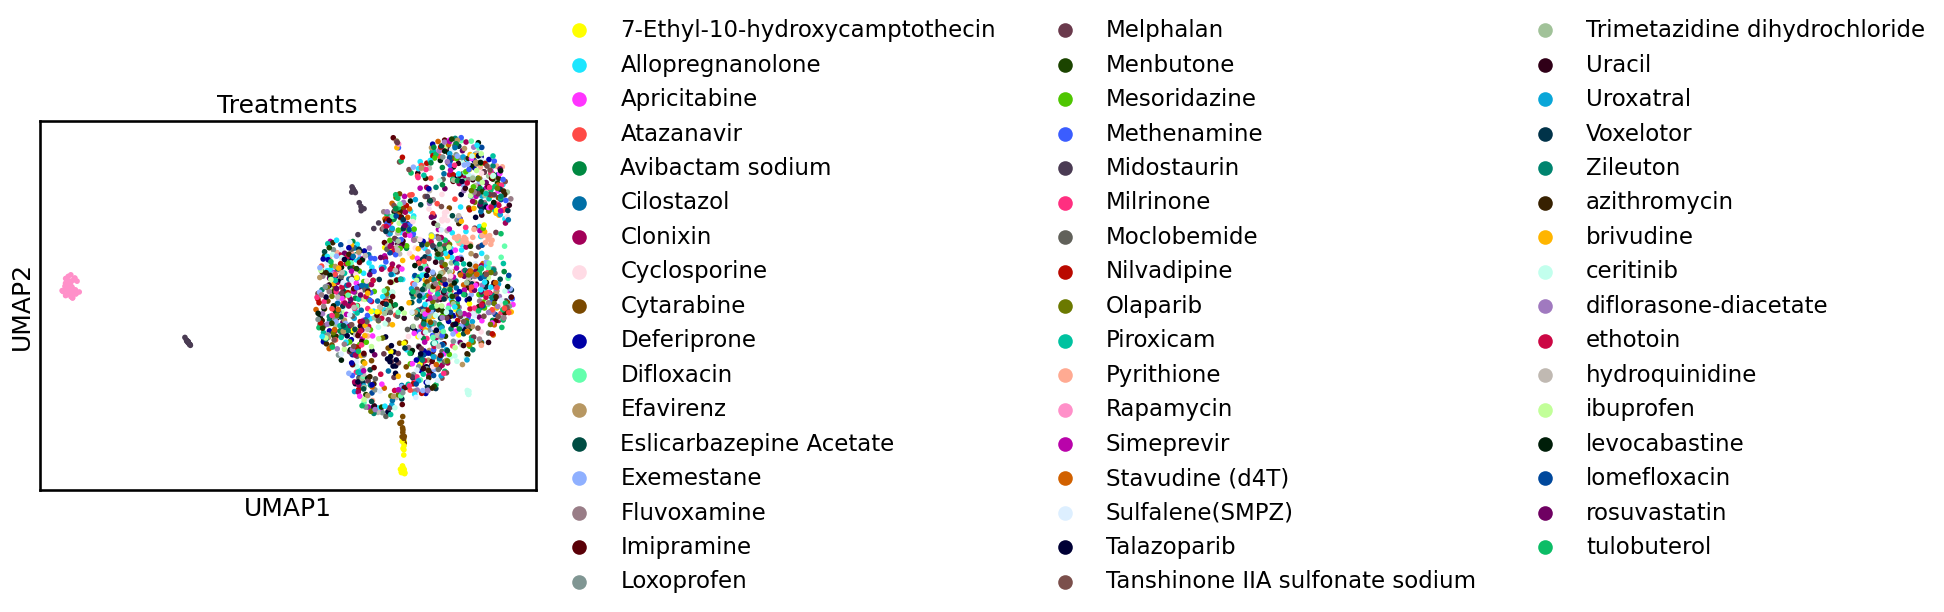

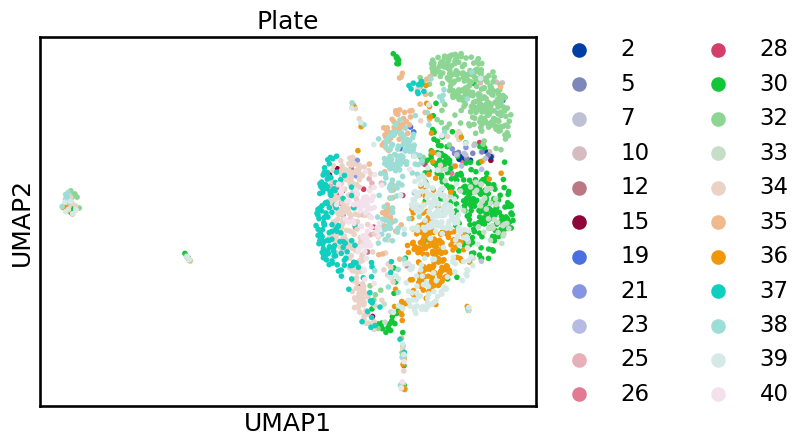

In [14]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep = "X")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["treatment"], title = "Treatments")
sc.pl.umap(adata, color="plate", title = "Plate")

Since there are too many treatments to investigate them all, we subset for the top 50 most frequent treatments. 

We see clustering of some treatments but the clustering by plate is stronger. However, we also see and expect some overlay or intermixing of the clusters because all these treatments are experimental with the goal of trying to counteract the storm-svere level of cytokine activitiy as found in severe COVID-19 patients. Thus, not all treatments may be equally effective.

Thus, our batch key is "plate" and the label key (the biology we want to preserve) is "treatment".

### B. Find which metrics are applicable for this dataset<a class="anchor" id="before_sub2"></a>


The computed metrics for removal of batch effects are:

- Graph connectivity score 
- iLISI
- (kBET)
- PCR
- Silhouette batch 

Regarding kBET, it was not run as it kept killing the kernal session.
Regarding the PCR: this score is computed after integration once with the comparison (scib.metrics.pcr_comparison()) and once without the comparison (scib.metrics.pcr()).

The following biological conservation metrics are calculated:

- cLISI
- Silhouette biological
- NMI 
- ARI
- Isolated Label score F1
- Isolated Label score ASW

The isolated label score is also considered for this dataset, because in each batch, i.e. plate, we do not always have all labels. Specifically, only plate 53 has all three disease_conditions "blank", "healthy" and "storm-severe". Thus the label "blank" is only present in one batch, i.e. one plate.


Metrics excluded for this dataset are:

- Cell Cycle Conservation score
- HVG Overlap 
- Trajectory Conservation

We exclude the CCC, HVG Overlap and Trajectory Conservation score for this dataset, because we have image embeddings.

### C. Compute scIB metrics <a class="anchor" id="before_sub3"></a>

#### i. Batch correction metrics <a class="anchor" id="scIB_sub1"></a>

In [5]:
#Graph connectivity score
sc.pp.neighbors(adata, n_neighbors=15, use_rep = "X")
gc = scib.me.graph_connectivity(adata, label_key="treatment")

In [6]:
#iLISI
ilisi = scib.me.ilisi_graph(adata, batch_key="plate", type_="knn")

Chunk 89 does not have enough neighbors. Skipping...
Chunk 179 does not have enough neighbors. Skipping...
Chunk 181 does not have enough neighbors. Skipping...
Chunk 185 does not have enough neighbors. Skipping...
Chunk 348 does not have enough neighbors. Skipping...
Chunk 385 does not have enough neighbors. Skipping...
Chunk 404 does not have enough neighbors. Skipping...
Chunk 410 does not have enough neighbors. Skipping...
Chunk 598 does not have enough neighbors. Skipping...
Chunk 615 does not have enough neighbors. Skipping...
Chunk 621 does not have enough neighbors. Skipping...
Chunk 707 does not have enough neighbors. Skipping...
Chunk 752 does not have enough neighbors. Skipping...
Chunk 781 does not have enough neighbors. Skipping...
Chunk 787 does not have enough neighbors. Skipping...
Chunk 838 does not have enough neighbors. Skipping...
Chunk 874 does not have enough neighbors. Skipping...
Chunk 1050 does not have enough neighbors. Skipping...
Chunk 1093 does not have eno

In [7]:
#kbet
#kbet = scib.me.kBET(adata, batch_key="plate", label_key=treatment_labels, type_="knn")

In [8]:
#principal component regression, computes PCA if not provided: 
pcr_nc = scib.me.pcr(adata, covariate="plate")

In [9]:
#silhouette batch 
#only takes a slot in .obsm as input, i.e. embedding or pca -> compute PCA 
sc.pp.pca(adata, n_comps = 100)
silhouette_batch = scib.me.silhouette_batch(adata, batch_key="plate", label_key="treatment", embed="X_pca")

mean silhouette per group:                                  silhouette_score
group                                            
7-Ethyl-10-hydroxycamptothecin           0.903794
Allopregnanolone                         0.898476
Apricitabine                             0.884856
Atazanavir                               0.879607
Avibactam sodium                         0.924780
Cilostazol                               0.918950
Clonixin                                 0.897020
Cyclosporine                             0.876156
Cytarabine                               0.831804
Deferiprone                              0.904751
Difloxacin                               0.912687
Efavirenz                                0.884278
Eslicarbazepine Acetate                  0.891938
Exemestane                               0.910431
Fluvoxamine                              0.867357
Imipramine                               0.866912
Loxoprofen                               0.821054
Melphalan              

#### ii. Biological conservation metrics <a class="anchor" id="scIB_sub2"></a>

In [10]:
#cell type lisi -> specify it as "knn"
clisi = scib.me.clisi_graph(adata, label_key="treatment", type_="knn")

Chunk 89 does not have enough neighbors. Skipping...
Chunk 179 does not have enough neighbors. Skipping...
Chunk 181 does not have enough neighbors. Skipping...
Chunk 185 does not have enough neighbors. Skipping...
Chunk 348 does not have enough neighbors. Skipping...
Chunk 385 does not have enough neighbors. Skipping...
Chunk 404 does not have enough neighbors. Skipping...
Chunk 410 does not have enough neighbors. Skipping...
Chunk 598 does not have enough neighbors. Skipping...
Chunk 615 does not have enough neighbors. Skipping...
Chunk 621 does not have enough neighbors. Skipping...
Chunk 707 does not have enough neighbors. Skipping...
Chunk 752 does not have enough neighbors. Skipping...
Chunk 781 does not have enough neighbors. Skipping...
Chunk 787 does not have enough neighbors. Skipping...
Chunk 838 does not have enough neighbors. Skipping...
Chunk 874 does not have enough neighbors. Skipping...
Chunk 1050 does not have enough neighbors. Skipping...
Chunk 1093 does not have eno

In [11]:
#silhouette biological
silhouette = scib.me.silhouette(adata, label_key="treatment", embed="X_pca")

In [12]:
#NMI
# cluster_optimal_resolution uses precomputed knn if use_rep == None
nmi = scib.metrics.cluster_optimal_resolution(adata, label_key = "treatment",cluster_key = "cluster", metric = scib.me.nmi, return_all = True)[1]

resolution: 0.1, nmi: 0.09545976029936457
resolution: 0.2, nmi: 0.09973821824698395
resolution: 0.3, nmi: 0.1065948582505572
resolution: 0.4, nmi: 0.1256338460977594
resolution: 0.5, nmi: 0.12324694733839331
resolution: 0.6, nmi: 0.13206838043683863
resolution: 0.7, nmi: 0.1341510657391389
resolution: 0.8, nmi: 0.13995282934867154
resolution: 0.9, nmi: 0.14683544913234958
resolution: 1.0, nmi: 0.14336601284689082
resolution: 1.1, nmi: 0.15572829931985746
resolution: 1.2, nmi: 0.15432444164215386
resolution: 1.3, nmi: 0.16256393346006212
resolution: 1.4, nmi: 0.16202147587895666
resolution: 1.5, nmi: 0.1662019884666536
resolution: 1.6, nmi: 0.17003418604319193
resolution: 1.7, nmi: 0.17039848089424098
resolution: 1.8, nmi: 0.17276202822404832
resolution: 1.9, nmi: 0.18309133609109907
resolution: 2.0, nmi: 0.18317013804335142
optimised clustering against treatment
optimal cluster resolution: 2.0
optimal score: 0.18317013804335142


In [13]:
#ARI
# cluster_optimal_resolution uses precomputed knn if use_rep == None
ari = scib.metrics.cluster_optimal_resolution(adata, label_key = "treatment",cluster_key = "cluster", metric = scib.me.ari, return_all = True)[1]

resolution: 0.1, ari: 0.002632584583180162
resolution: 0.2, ari: 0.00587275105783089
resolution: 0.3, ari: 0.0067157324068626055
resolution: 0.4, ari: 0.009275113831835623
resolution: 0.5, ari: 0.012609457864979344
resolution: 0.6, ari: 0.012663466334072022
resolution: 0.7, ari: 0.013048428886319944
resolution: 0.8, ari: 0.014885736325139214
resolution: 0.9, ari: 0.0157001633645744
resolution: 1.0, ari: 0.015490112265357849
resolution: 1.1, ari: 0.02002228071789682
resolution: 1.2, ari: 0.021037496854474556
resolution: 1.3, ari: 0.02286990885383671
resolution: 1.4, ari: 0.02332113583961737
resolution: 1.5, ari: 0.02331607082667004
resolution: 1.6, ari: 0.024910080488172184
resolution: 1.7, ari: 0.024041311129648614
resolution: 1.8, ari: 0.024841616592707776
resolution: 1.9, ari: 0.026922789739507253
resolution: 2.0, ari: 0.025196025526271083
optimised clustering against treatment
optimal cluster resolution: 1.9
optimal score: 0.026922789739507253


In [14]:
#Isolated label score F1
isolated_label_F1 = scib.me.isolated_labels_f1(adata, batch_key="plate", label_key="treatment", embed = "X_pca")

isolated labels: no more than 6 batches per label
Compute neighbors on rep X_pca
7-Ethyl-10-hydroxycamptothecin: 0.5538461538461539
Compute neighbors on rep X_pca
Apricitabine: 0.10204081632653061
Compute neighbors on rep X_pca
Atazanavir: 0.125
Compute neighbors on rep X_pca
Avibactam sodium: 0.08856088560885607
Compute neighbors on rep X_pca
Cilostazol: 0.11267605633802817
Compute neighbors on rep X_pca
Clonixin: 0.15
Compute neighbors on rep X_pca
Cyclosporine: 0.2857142857142857
Compute neighbors on rep X_pca
Cytarabine: 0.3384615384615385
Compute neighbors on rep X_pca
Deferiprone: 0.08219178082191782
Compute neighbors on rep X_pca
Difloxacin: 0.08450704225352113
Compute neighbors on rep X_pca
Efavirenz: 0.06535947712418301
Compute neighbors on rep X_pca
Eslicarbazepine Acetate: 0.08450704225352113
Compute neighbors on rep X_pca
Exemestane: 0.078125
Compute neighbors on rep X_pca
Fluvoxamine: 0.08421052631578949
Compute neighbors on rep X_pca
Imipramine: 0.099009900990099
Compute 

In [15]:
#Isolated label score ASW
isolated_label_ASW = scib.me.isolated_labels_asw(adata, batch_key="plate", label_key="treatment", embed="X_pca")

isolated labels: no more than 6 batches per label
7-Ethyl-10-hydroxycamptothecin: 0.4125955179333687
Apricitabine: 0.4727020934224129
Atazanavir: 0.44375456124544144
Avibactam sodium: 0.4835966154932976
Cilostazol: 0.4706479236483574
Clonixin: 0.4807825796306133
Cyclosporine: 0.4298207089304924
Cytarabine: 0.413736954331398
Deferiprone: 0.46081631630659103
Difloxacin: 0.4654487855732441
Efavirenz: 0.4514993578195572
Eslicarbazepine Acetate: 0.4682326912879944
Exemestane: 0.46692948043346405
Fluvoxamine: 0.47670794650912285
Imipramine: 0.44540534541010857
Loxoprofen: 0.46279530227184296
Melphalan: 0.42224638164043427
Menbutone: 0.463410634547472
Mesoridazine: 0.4867456117644906
Methenamine: 0.43620825558900833
Midostaurin: 0.46883933804929256
Milrinone: 0.46893733739852905
Moclobemide: 0.46435951068997383
Nilvadipine: 0.43254830688238144
Olaparib: 0.47114061564207077
Piroxicam: 0.46271077543497086
Pyrithione: 0.4731005132198334
Rapamycin: 0.7196025401353836
Simeprevir: 0.472481869161129

#### iii. Have a look at result <a class="anchor" id="scIB_sub3"></a>
Unintegrated results

1. Batch correction metrics

In [45]:
unintegrated_metrics = pd.DataFrame({"Unintegrated: Batch correction metrics": []})

unintegrated_metrics.loc["Graph_Conn"] = gc
unintegrated_metrics.loc["iLISI"] = ilisi
unintegrated_metrics.loc["PCR_NC"] = pcr_nc
unintegrated_metrics.loc["PCR_Comparison"] = None
#unintegrated_metrics.loc["kBET"] = kbet
unintegrated_metrics.loc["Silhouette_batch"] = silhouette_batch

unintegrated_metrics

,Unintegrated: Batch correction metrics
Graph_Conn,0.227222
iLISI,0.078027
PCR_NC,0.156220
PCR_Comparison,NaN
Silhouette_batch,0.889508


Graph connectivity score:
- Score range: ranges from 0 to 1.
- Meaning: measures the connectedness of cells within each batch after applying batch correction. A higher score closer to 1 indicates that the batch correction has successfully increased the connectivity and reduced the isolation of cells within each batch. It implies that cells within the same biological group or condition are more interconnected and grouped together, while cells from different batches are more separated.

iLISI:
- Score range: ranges from 0 to 1.
- Meaning: quantifies the consistency of local neighborhood relationships within and between batches. A higher iLISI score closer to 1 suggests better batch correction performance. It indicates that cells within the same batch have more consistent neighborhood relationships, resembling cells from the same biological condition, while cells from different batches have distinct neighborhood relationships.

kBET:
- Score range: ranges from 0 to 1.
- Meaning: assesses the batch effects in single-cell RNA-seq data. A score closer to 0 indicates strong batch effects, meaning that the variation between batches dominates the biological variation. A score closer to 1 indicates minimal batch effects, suggesting that the biological variation is the primary driver of the observed differences.

PCR:
- Score range: ranges from negative to positive values.
- Meaning: utilizes principal component analysis (PCA) to reduce the dimensionality of the data and perform regression analysis for batch correction. The score represents the performance of the regression model, where higher positive scores indicate better prediction accuracy and successful batch correction. Conversely, lower negative scores indicate poorer prediction accuracy and less effective batch correction.

Silhouette batch:
- Score range: ranges from -1 to 1.
- Meaning: measures the quality of batch correction by assessing the separation between cells from different batches. A higher silhouette batch score closer to 1 indicates better batch correction. It implies that cells within the same biological condition are well-separated from cells of other conditions, suggesting successful removal or reduction of batch effects. Conversely, a score closer to -1 indicates poor batch correction, where cells from different batches are not well-separated.

2. Biological conservation metrics

In [46]:
unintegrated_metrics_1 = pd.DataFrame({"Unintegrated: biol. conservation metrics": []})

unintegrated_metrics_1.loc["cLISI"] = clisi
unintegrated_metrics_1.loc["Silhouette"] = silhouette
unintegrated_metrics_1.loc["NMI"] = nmi
unintegrated_metrics_1.loc["ARI"] = ari
unintegrated_metrics_1.loc["Isolated_label_F1"] = isolated_label_F1
unintegrated_metrics_1.loc["Isolated_label_ASW"] = isolated_label_ASW

unintegrated_metrics_1

,Unintegrated: biol. conservation metrics
cLISI,0.794497
Silhouette,0.466110
NMI,0.183170
ARI,0.026923
Isolated_label_F1,0.158131
Isolated_label_ASW,0.466494


cLISI:
- Score range: ranges from 0 to 1.
- Meaning: quantifies the consistency of local neighborhood relationships of cell types within and between batches. A higher cLISI score closer to 1 suggests better batch correction performance. It indicates that the neighborhood relationships of cell types are more consistent within the same batch, resembling the biological structure, while being distinct from cell types in different batches.

Silhouette Biological:
- Score range: ranges from -1 to 1.
- Meaning: measures the quality of batch correction by evaluating the separation between different cell types or biological conditions. A higher silhouette biological score closer to 1 indicates better batch correction. It suggests that cells from the same biological condition are well-separated from cells of other conditions, indicating successful removal or reduction of batch effects. Conversely, a score closer to -1 indicates poor batch correction, where cell types or biological conditions are not well-separated.

NMI:
- Score range: ranges from 0 to 1.
- Meaning: quantifies the similarity between the clustering results of different batches or conditions. A higher NMI score closer to 1 suggests better batch correction. It indicates a high degree of similarity between the cluster assignments of cells within the same biological condition, reflecting successful batch effect removal. A score of 0 indicates no mutual information or similarity between the clusters.

ARI:
- Score range: ranges from -1 to 1.
- Meaning: measures the similarity between the cluster assignments of different batches or conditions, adjusted for chance. A higher ARI score closer to 1 indicates better batch correction. It suggests a high degree of similarity between the cluster assignments of cells within the same biological condition, reflecting successful batch effect removal. A score of 0 indicates the expected similarity by chance, while negative scores indicate dissimilarity.

Isolated Label Score F1:
- Score range: ranges from 0 to 1.
- Meaning: measures the preservation of cell type labels after batch correction. A higher F1 score closer to 1 indicates better preservation of cell type information. It suggests that the batch correction method has successfully maintained the cell type identities and avoided label changes across different batches.

Isolated Label Score ASW:
- Score range: ranges from -1 to 1.
- Meaning: measures the separation and compactness of cell type clusters after batch correction. A higher ASW score closer to 1 indicates better separation and compactness of cell type clusters. It suggests that cells of the same type form tight and well-separated clusters, indicating successful preservation of cell type information.

In [16]:
adata.write_h5ad(
    "rxrx19b_top_50_treatments.h5ad",
    compression="gzip"
)

## II. Integration  <a class="anchor" id="integrate"></a>

### A. Harmony <a class="anchor" id="integrate_sub1"></a>

In [17]:
harmony = adata.copy()
scib.integration.harmony(harmony, batch = "plate")

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


AnnData object with n_obs × n_vars = 1836 × 128
    obs: 'well_id', 'cell_type', 'experiment', 'plate', 'well', 'site', 'disease_condition', 'treatment', 'treatment_conc', 'SMILES'
    uns: 'neighbors', 'umap', 'treatment_colors', 'plate_colors', 'pca'
    obsm: 'X_umap', 'X_pca', 'X_emb'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### B. Scanorama <a class="anchor" id="integrate_sub2"></a>

In [13]:
scanorama = adata.copy()

# Convert 'plate' column to string
scanorama.obs['plate'] = scanorama.obs['plate'].astype(str)

# Convert 'plate' column to category dtype
scanorama.obs['plate'] = pd.Categorical(scanorama.obs['plate'])

# Perform scanorama integration
scanorama = scib.ig.scanorama(scanorama, batch='plate')

Found 128 genes among all datasets
[[0.         0.33333333 0.33333333 0.16666667 0.33333333 0.
  0.         0.33333333 0.33333333 0.5        0.5        0.83333333
  0.         0.5        0.5        0.         0.66666667 0.16666667
  0.16666667 0.         0.33333333 0.16666667]
 [0.         0.         0.33333333 0.         0.33333333 0.
  0.         0.16666667 0.         0.         0.16666667 0.16666667
  0.         1.         0.         0.         0.66666667 0.
  0.16666667 0.66666667 0.16666667 0.16666667]
 [0.         0.         0.         0.16666667 0.16666667 0.
  0.         0.5        0.         0.         0.5        0.66666667
  0.33333333 1.         0.         0.         0.83333333 0.5
  0.16666667 0.16666667 0.16666667 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.16666667 0.         0.         0.33333333 1.
  0.16666667 0.5        0.66666667 0.         0.16666667 0.5
  0.         0.         0.         0.        ]
 [0.         0.        

### C. scVI <a class="anchor" id="integrate_sub3"></a>

In [8]:
# Create a copy of the AnnData object
scVI = adata.copy()

# Convert 'plate' column to categorical
scVI.obs['plate'] = pd.Categorical(scVI.obs['plate'])

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
scVI.X = scaler.fit_transform(scVI.X)

# Set the normalized data as the 'counts' layer
scVI.layers["counts"] = scVI.X

# Run scVI
scVI = scib.integration.scvi(scVI, batch="plate")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB MIG 3g.20gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-ecda22eb-8abb-04f1-ab06-b2f421aa6b78/2/0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 400/400: 100%|██████████| 400/400 [00:38<00:00, 10.75it/s, v_num=1, train_loss_step=97.4, train_loss_epoch=97.3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:38<00:00, 10.51it/s, v_num=1, train_loss_step=97.4, train_loss_epoch=97.3]


### D. scANVI <a class="anchor" id="integrate_sub4"></a>

In [5]:
# Create a copy of the AnnData object
scANVI = adata.copy()

# Convert 'plate' column to categorical
scANVI.obs['plate'] = pd.Categorical(scANVI.obs['plate'])

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
scANVI.X = scaler.fit_transform(scANVI.X)

# Set the normalized data as the 'counts' layer
scANVI.layers["counts"] = scANVI.X

# Run scANVI
scANVI = scib.integration.scanvi(scANVI, batch="plate", labels="treatment")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB MIG 3g.20gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-3a69fd1d-def3-fc8a-dd5c-c76e297d14a8/1/0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 360/400:  90%|████████▉ | 359/400 [00:46<00:05,  7.68it/s, v_num=1, train_loss_step=98, train_loss_epoch=97.9]  INFO     Training for 10 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB MIG 3g.20gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-3a69fd1d-def3-fc8a-dd5c-c76e297d14a8/1/0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 10/10: 100%|██████████| 10/10 [00:03<00:00,  2.94it/s, v_num=1, train_loss_step=282, train_loss_epoch=278]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s, v_num=1, train_loss_step=282, train_loss_epoch=278]


### E. scGen <a class="anchor" id="integrate_sub5"></a>

In [8]:
# Create a copy of the AnnData object
scGen = adata.copy()

pt.tl.SCGEN.setup_anndata(scGen, batch_key="plate", labels_key="treatment")
model = pt.tl.SCGEN(scGen)
model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
)

scGen = model.batch_removal()
scGen

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
Multiprocessing is handled by SLURM.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 28/100:  28%|██▊       | 28/100 [00:22<00:57,  1.24it/s, v_num=1, train_loss_step=128, train_loss_epoch=208]  
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 185.893. Signaling Trainer to stop.
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


AnnData object with n_obs × n_vars = 1836 × 128
    obs: 'well_id', 'cell_type', 'experiment', 'plate', 'well', 'site', 'disease_condition', 'treatment', 'treatment_conc', 'SMILES', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent', 'corrected_latent'

## III. After integration  <a class="anchor" id="after"></a>

### A. Harmony: Compute scIB metrics <a class="anchor" id="after_sub1"></a>

In [11]:
# the following function expects an embedding output; X_emb
# can of course be adjusted so that it takes all integration outputs as input 
def compute_metrics_after(adata_pre, adata_post, label_key, batch_key, integration_method):
    results = scib.metrics.metrics(adata_pre, adata_post, batch_key, label_key, embed='X_emb', cluster_key='cluster',
                     ari_=True, nmi_=True,silhouette_=True, pcr_=True, graph_conn_=True, kBET_=False, lisi_graph_=True, 
                                   isolated_labels_ = True, isolated_labels_f1_ = True,  type_="emb")
    
    # compute only the principal component regression score without the comparison: 
    pcr = scib.me.pcr(adata_post, covariate=batch_key, embed="X_emb")
    #append pcr to results: 
    results.loc["PCR_NC"] = pcr
    # remove rows containing NaNs for metrics that weren't computed
    results = results.drop(["cell_cycle_conservation", "hvg_overlap", "trajectory"])
    #change row names: 
    results = results.rename({"graph_conn": "Graph_Conn", "PCR_batch": "PCR_Comparison", "ASW_label/batch": "Silhouette_batch",
                             "ASW_label": "Silhouette", "NMI_cluster/label": "NMI", "ARI_cluster/label": "ARI"}, axis='index')
    #change column name 
    results = results.rename(columns={0: integration_method})
    
    return results

In [19]:
harmony_metrics = compute_metrics_after(adata, harmony, "treatment", "plate", "Harmony") 

/home/mahim/.local/lib/python3.10/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
PC regression...
Isolated labels F1...
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_e

In [50]:
#harmony_metrics

# Create a list of row names to split on
split_rows = ["Graph_Conn", "iLISI", "PCR_NC", "PCR_Comparison", "Silhouette_batch"]

# Filter the DataFrame based on the split rows
harmony_batch_correction = harmony_metrics.loc[split_rows].copy()
harmony_biological_conservation = harmony_metrics.drop(split_rows).copy()

# Drop the "kBET" row from harmony_biological_conservation
harmony_biological_conservation.drop("kBET", inplace=True)

# Rename the column in harmony_batch_correction
harmony_batch_correction = harmony_batch_correction.rename(columns={"Harmony": "Harmony: Batch_correction metrics"})

# Rename the column in harmony_other
harmony_biological_conservation = harmony_biological_conservation.rename(columns={"Harmony": "Harmony: biol. conservation metrics"})

In [51]:
# Print the resulting DataFrames
harmony_batch_correction

,Harmony: Batch_correction metrics
Graph_Conn,0.227222
iLISI,0.078573
PCR_NC,0.033015
PCR_Comparison,0.788664
Silhouette_batch,0.882341


In [52]:
harmony_biological_conservation

,Harmony: biol. conservation metrics
NMI,0.168141
ARI,0.027764
Silhouette,0.464476
isolated_label_F1,0.158302
isolated_label_silhouette,0.464572
cLISI,0.795914


### B. Harmony: Before and after UMAP visualization <a class="anchor" id="after_sub2"></a>

<b> Unintegrated: <b>

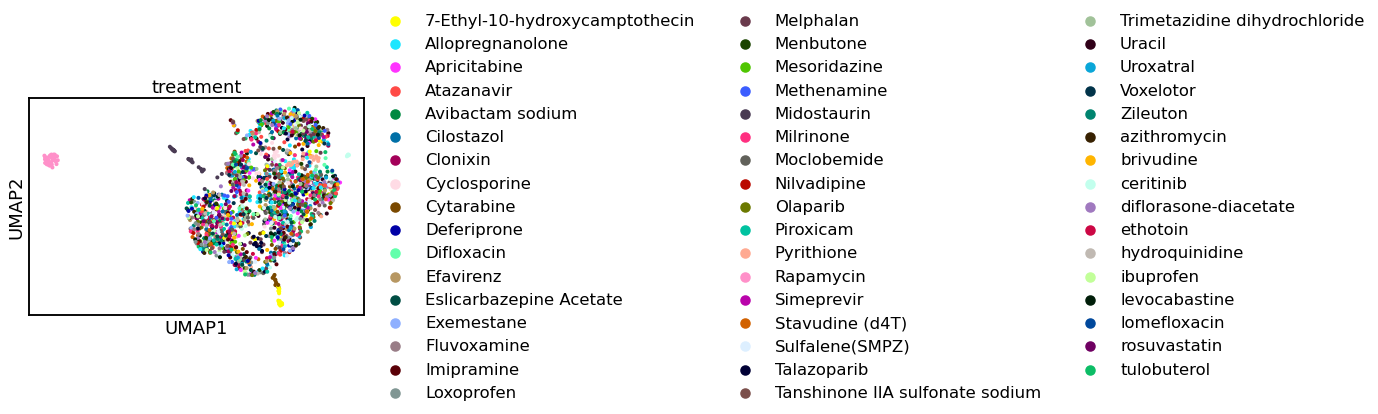

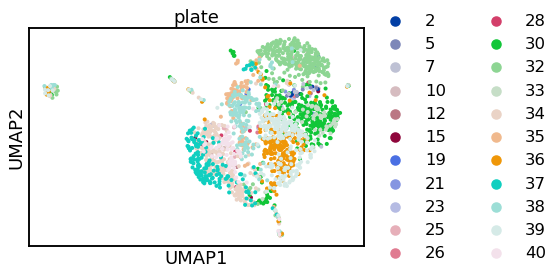

In [53]:
sc.pl.umap(adata, color="treatment")
sc.pl.umap(adata, color="plate")

<b> After harmony integration: <b>

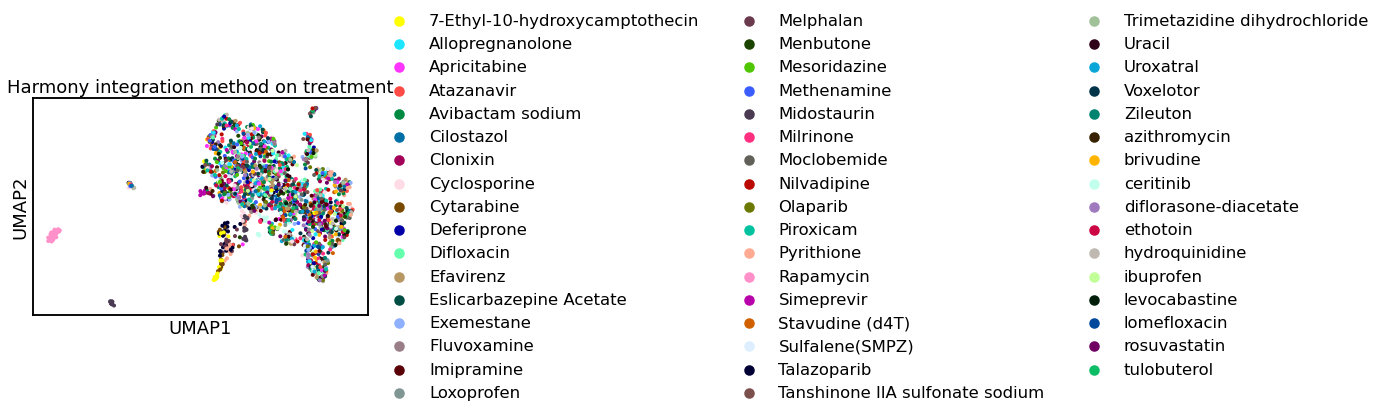

In [54]:
sc.pp.neighbors(harmony, n_neighbors=15, use_rep = "X_emb")
sc.tl.umap(harmony)
sc.pl.umap(harmony, color= "treatment", title = "Harmony integration method on treatment")

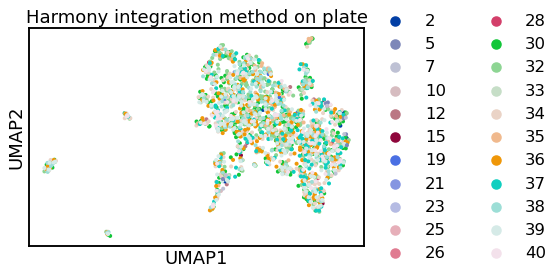

In [55]:
sc.pl.umap(harmony, color= "plate", title = "Harmony integration method on plate")

We clearly see that the plate effect is drastically reduced after integration with harmony. 

In [20]:
harmony.write_h5ad(
    "rxrx19b_top_50_treatments_harmony.h5ad",
    compression="gzip"
)

### C. Scanorama: Compute scIB metrics <a class="anchor" id="after_sub3"></a>

#### i. Batch correction metrics <a class="anchor" id="scIB_sub1"></a>

In [14]:
#Graph connectivity
sc.pp.neighbors(scanorama, n_neighbors=15, use_rep = "X")
scanorama.obs['treatment'] = pd.Categorical(scanorama.obs['treatment'])
gc = scib.me.graph_connectivity(scanorama, label_key="treatment")

In [15]:
#iLISI
ilisi = scib.me.ilisi_graph(scanorama, batch_key="plate", type_="knn")

Chunk 89 does not have enough neighbors. Skipping...
Chunk 179 does not have enough neighbors. Skipping...
Chunk 181 does not have enough neighbors. Skipping...
Chunk 185 does not have enough neighbors. Skipping...
Chunk 348 does not have enough neighbors. Skipping...
Chunk 385 does not have enough neighbors. Skipping...
Chunk 404 does not have enough neighbors. Skipping...
Chunk 410 does not have enough neighbors. Skipping...
Chunk 598 does not have enough neighbors. Skipping...
Chunk 615 does not have enough neighbors. Skipping...
Chunk 621 does not have enough neighbors. Skipping...
Chunk 707 does not have enough neighbors. Skipping...
Chunk 752 does not have enough neighbors. Skipping...
Chunk 781 does not have enough neighbors. Skipping...
Chunk 787 does not have enough neighbors. Skipping...
Chunk 838 does not have enough neighbors. Skipping...
Chunk 874 does not have enough neighbors. Skipping...
Chunk 1050 does not have enough neighbors. Skipping...
Chunk 1093 does not have eno

In [16]:
#principal component regression, computes PCA if not provided: 
pcr_nc = scib.me.pcr(scanorama, covariate="plate")

In [17]:
#silhouette batch 
#only takes a slot in .obsm as input, i.e. embedding or pca -> compute PCA 
sc.pp.pca(scanorama, n_comps = 100)
silhouette_batch = scib.me.silhouette_batch(scanorama, batch_key="plate", label_key="treatment", embed="X_emb")

mean silhouette per group:                                  silhouette_score
group                                            
7-Ethyl-10-hydroxycamptothecin           0.884193
Allopregnanolone                         0.858768
Apricitabine                             0.864755
Atazanavir                               0.897260
Avibactam sodium                         0.915725
Cilostazol                               0.901444
Clonixin                                 0.876560
Cyclosporine                             0.880730
Cytarabine                               0.890867
Deferiprone                              0.915140
Difloxacin                               0.911428
Efavirenz                                0.859374
Eslicarbazepine Acetate                  0.878949
Exemestane                               0.909885
Fluvoxamine                              0.923281
Imipramine                               0.909144
Loxoprofen                               0.878534
Melphalan              

#### ii. Biological conservation metrics <a class="anchor" id="scIB_sub2"></a>

In [18]:
# Convert the column to a categorical variable with string values
scanorama.obs['treatment'] = scanorama.obs['treatment'].astype(str)
scanorama.obs['treatment'] = pd.Categorical(scanorama.obs['treatment'])

# Calculate cLISI graph
clisi = scib.me.clisi_graph(scanorama, label_key="treatment", type_="knn")

Chunk 89 does not have enough neighbors. Skipping...
Chunk 179 does not have enough neighbors. Skipping...
Chunk 181 does not have enough neighbors. Skipping...
Chunk 185 does not have enough neighbors. Skipping...
Chunk 348 does not have enough neighbors. Skipping...
Chunk 385 does not have enough neighbors. Skipping...
Chunk 404 does not have enough neighbors. Skipping...
Chunk 410 does not have enough neighbors. Skipping...
Chunk 598 does not have enough neighbors. Skipping...
Chunk 615 does not have enough neighbors. Skipping...
Chunk 621 does not have enough neighbors. Skipping...
Chunk 707 does not have enough neighbors. Skipping...
Chunk 752 does not have enough neighbors. Skipping...
Chunk 781 does not have enough neighbors. Skipping...
Chunk 787 does not have enough neighbors. Skipping...
Chunk 838 does not have enough neighbors. Skipping...
Chunk 874 does not have enough neighbors. Skipping...
Chunk 1050 does not have enough neighbors. Skipping...
Chunk 1093 does not have eno

In [19]:
#silhouette biological
silhouette = scib.me.silhouette(scanorama, label_key="treatment", embed="X_emb")

In [20]:
#NMI
# cluster_optimal_resolution uses precomputed knn if use_rep == None
nmi = scib.metrics.cluster_optimal_resolution(scanorama, label_key = "treatment",cluster_key = "cluster", metric = scib.me.nmi, return_all = True)[1]

resolution: 0.1, nmi: 0.09482885133733276
resolution: 0.2, nmi: 0.09975695796071311
resolution: 0.3, nmi: 0.09926344310796346
resolution: 0.4, nmi: 0.1027754029368964
resolution: 0.5, nmi: 0.10906930913587075
resolution: 0.6, nmi: 0.11840479248601521
resolution: 0.7, nmi: 0.13187814085745275
resolution: 0.8, nmi: 0.12966587664961052
resolution: 0.9, nmi: 0.1334319652477578
resolution: 1.0, nmi: 0.13195505131828103
resolution: 1.1, nmi: 0.13329751226310935
resolution: 1.2, nmi: 0.13474788579115635
resolution: 1.3, nmi: 0.14272568772687466
resolution: 1.4, nmi: 0.14276602879714204
resolution: 1.5, nmi: 0.1450774108567062
resolution: 1.6, nmi: 0.15377498017768293
resolution: 1.7, nmi: 0.15264018845576025
resolution: 1.8, nmi: 0.15833767308478527
resolution: 1.9, nmi: 0.16812231724970586
resolution: 2.0, nmi: 0.17146605422968245
optimised clustering against treatment
optimal cluster resolution: 2.0
optimal score: 0.17146605422968245


In [21]:
#ARI
# cluster_optimal_resolution uses precomputed knn if use_rep == None
ari = scib.metrics.cluster_optimal_resolution(scanorama, label_key = "treatment",cluster_key = "cluster", metric = scib.me.ari, return_all = True)[1]

resolution: 0.1, ari: 0.005137903887590697
resolution: 0.2, ari: 0.006285104761468743
resolution: 0.3, ari: 0.006247813412575575
resolution: 0.4, ari: 0.008299809052320098
resolution: 0.5, ari: 0.009161669017588654
resolution: 0.6, ari: 0.011130758704141196
resolution: 0.7, ari: 0.011791350722543625
resolution: 0.8, ari: 0.013302366373130151
resolution: 0.9, ari: 0.013773458079048439
resolution: 1.0, ari: 0.016107254417067524
resolution: 1.1, ari: 0.01715820109003878
resolution: 1.2, ari: 0.017649227864115657
resolution: 1.3, ari: 0.019995218947459877
resolution: 1.4, ari: 0.020032548316976397
resolution: 1.5, ari: 0.021161899156275657
resolution: 1.6, ari: 0.022405818306669257
resolution: 1.7, ari: 0.022793595645434508
resolution: 1.8, ari: 0.02420535382203752
resolution: 1.9, ari: 0.02414831993553433
resolution: 2.0, ari: 0.024780684287758224
optimised clustering against treatment
optimal cluster resolution: 2.0
optimal score: 0.024780684287758224


In [24]:
#Isolated label score F1
isolated_label_F1 = scib.me.isolated_labels_f1(scanorama, batch_key="plate", label_key="treatment", embed = "X_emb")

isolated labels: no more than 6 batches per label
Compute neighbors on rep X_emb
7-Ethyl-10-hydroxycamptothecin: 0.3801652892561983
Compute neighbors on rep X_emb
Apricitabine: 0.09195402298850575
Compute neighbors on rep X_emb
Atazanavir: 0.12962962962962962
Compute neighbors on rep X_emb
Avibactam sodium: 0.08411214953271028
Compute neighbors on rep X_emb
Cilostazol: 0.08163265306122448
Compute neighbors on rep X_emb
Clonixin: 0.0916030534351145
Compute neighbors on rep X_emb
Cyclosporine: 0.2857142857142857
Compute neighbors on rep X_emb
Cytarabine: 0.2698412698412698
Compute neighbors on rep X_emb
Deferiprone: 0.0909090909090909
Compute neighbors on rep X_emb
Difloxacin: 0.11538461538461539
Compute neighbors on rep X_emb
Efavirenz: 0.11764705882352941
Compute neighbors on rep X_emb
Eslicarbazepine Acetate: 0.06399999999999999
Compute neighbors on rep X_emb
Exemestane: 0.07407407407407407
Compute neighbors on rep X_emb
Fluvoxamine: 0.09022556390977443
Compute neighbors on rep X_emb


In [25]:
#Isolated label score ASW
isolated_label_ASW = scib.me.isolated_labels_asw(scanorama, batch_key="plate", label_key="treatment", embed="X_emb")

isolated labels: no more than 6 batches per label
7-Ethyl-10-hydroxycamptothecin: 0.43836245327535195
Apricitabine: 0.4663806433097811
Atazanavir: 0.4450015005726731
Avibactam sodium: 0.4856690969154039
Cilostazol: 0.4705456683928507
Clonixin: 0.47312607000758894
Cyclosporine: 0.42826706170130086
Cytarabine: 0.449646936158142
Deferiprone: 0.45524779836537205
Difloxacin: 0.4598131895838061
Efavirenz: 0.4463586272351767
Eslicarbazepine Acetate: 0.4548194048929408
Exemestane: 0.463617274337526
Fluvoxamine: 0.47699428328784543
Imipramine: 0.45160727416199115
Loxoprofen: 0.45706236749615003
Melphalan: 0.41738828507299597
Menbutone: 0.45685235186734807
Mesoridazine: 0.4897726719905032
Methenamine: 0.435433323541274
Midostaurin: 0.4513433922751178
Milrinone: 0.4632366113897204
Moclobemide: 0.46337633132792777
Nilvadipine: 0.438539620704239
Olaparib: 0.4624086325496309
Piroxicam: 0.4554343170377959
Pyrithione: 0.465587533200219
Rapamycin: 0.700695568226103
Simeprevir: 0.46568232118401237
Stavu

#### iii. Have a look at result <a class="anchor" id="scIB_sub3"></a>
Unintegrated results

1. Batch correction metrics

In [26]:
scanorama_metrics = pd.DataFrame({"Scanorama: Batch correction metrics": []})

scanorama_metrics.loc["Graph_Conn"] = gc
scanorama_metrics.loc["iLISI"] = ilisi
scanorama_metrics.loc["PCR_NC"] = pcr_nc
scanorama_metrics.loc["PCR_Comparison"] = None
scanorama_metrics.loc["Silhouette_batch"] = silhouette_batch

scanorama_metrics

,Scanorama: Batch correction metrics
Graph_Conn,0.228056
iLISI,0.147733
PCR_NC,0.093755
PCR_Comparison,NaN
Silhouette_batch,0.892409


2. Biological conservation metrics

In [27]:
scanorama_metrics_1 = pd.DataFrame({"Scanorama: biol. conservation metrics": []})

scanorama_metrics_1.loc["cLISI"] = clisi
scanorama_metrics_1.loc["Silhouette"] = silhouette
scanorama_metrics_1.loc["NMI"] = nmi
scanorama_metrics_1.loc["ARI"] = ari
scanorama_metrics_1.loc["Isolated_label_F1"] = isolated_label_F1
scanorama_metrics_1.loc["Isolated_label_ASW"] = isolated_label_ASW

scanorama_metrics_1

,Scanorama: biol. conservation metrics
cLISI,0.795754
Silhouette,0.463865
NMI,0.171466
ARI,0.024781
Isolated_label_F1,0.144897
Isolated_label_ASW,0.464010


### D. Scanorama: Before and after UMAP visualization <a class="anchor" id="after_sub4"></a>

<b> After scanorama integration: <b>

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


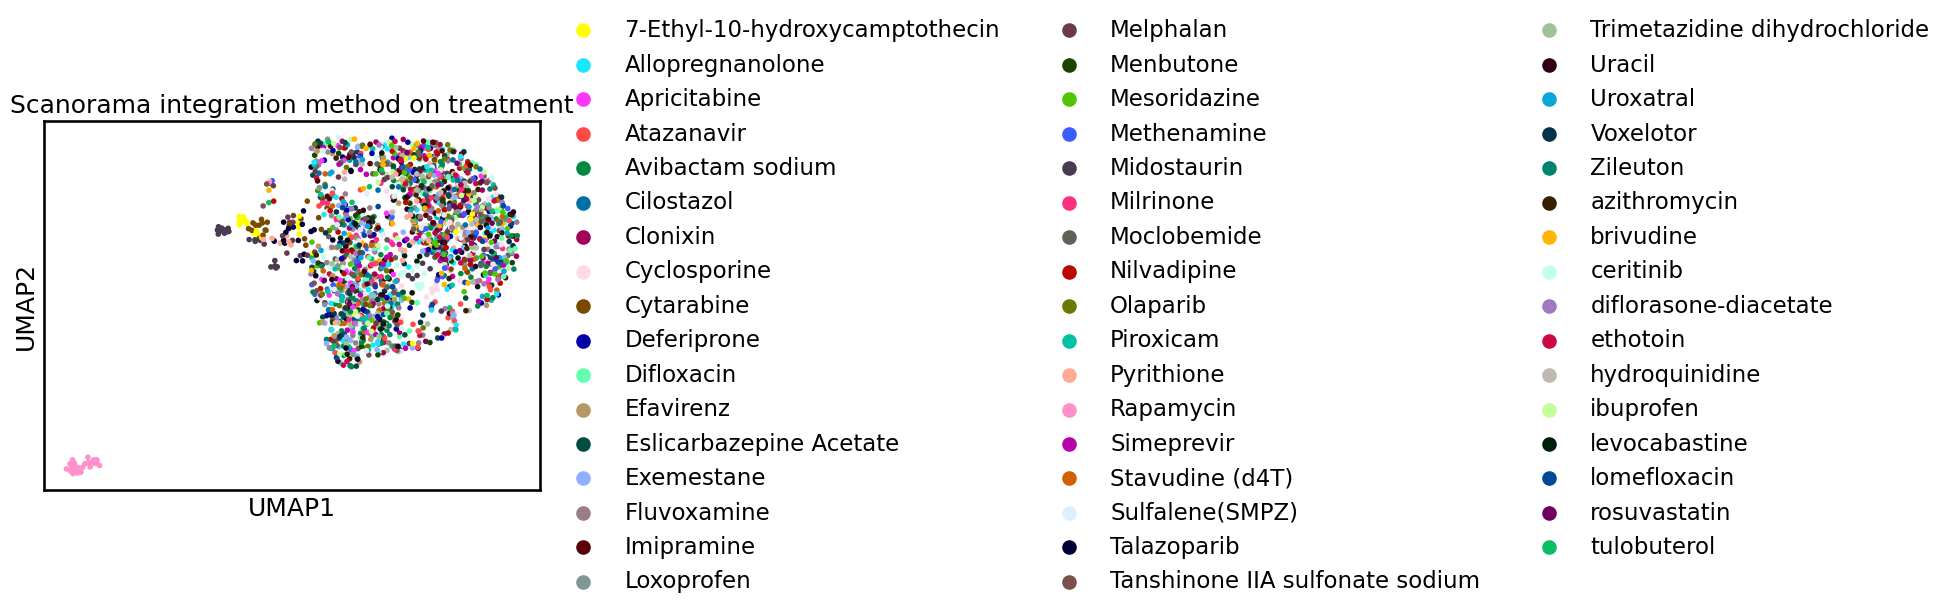

In [30]:
sc.pp.pca(scanorama)
sc.pp.neighbors(scanorama, n_neighbors=15, use_rep = "X_pca")
sc.tl.umap(scanorama)
sc.pl.umap(scanorama, color= "treatment", title = "Scanorama integration method on treatment")

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


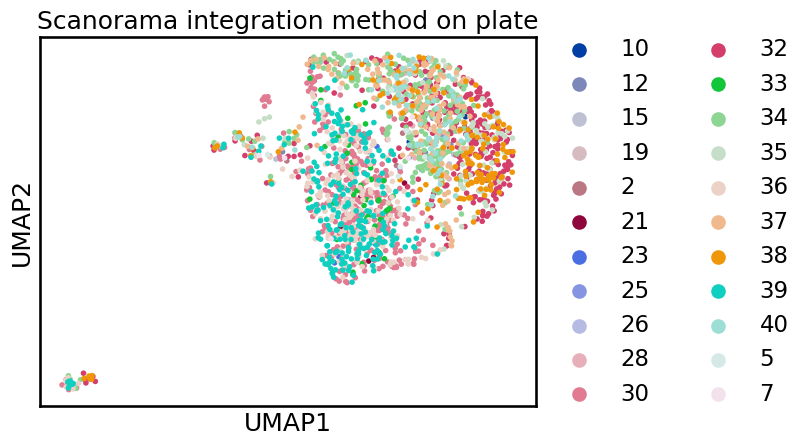

In [31]:
sc.pl.umap(scanorama, color= "plate", title = "Scanorama integration method on plate")

In [32]:
scanorama.write_h5ad(
    "rxrx19b_top_50_treatments_scanorama.h5ad",
    compression="gzip"
)

### E. scVI: Compute scIB metrics <a class="anchor" id="after_sub5"></a>

#### i. Batch correction metrics <a class="anchor" id="scIB_sub1"></a>

In [10]:
#Graph connectivity
sc.pp.neighbors(scVI, n_neighbors=15, use_rep = "X")
scVI.obs['treatment'] = pd.Categorical(scVI.obs['treatment'])
gc = scib.me.graph_connectivity(scVI, label_key="treatment")

In [11]:
#iLISI
ilisi = scib.me.ilisi_graph(scVI, batch_key="plate", type_="knn")

Chunk 89 does not have enough neighbors. Skipping...
Chunk 179 does not have enough neighbors. Skipping...
Chunk 181 does not have enough neighbors. Skipping...
Chunk 185 does not have enough neighbors. Skipping...
Chunk 348 does not have enough neighbors. Skipping...
Chunk 385 does not have enough neighbors. Skipping...
Chunk 404 does not have enough neighbors. Skipping...
Chunk 410 does not have enough neighbors. Skipping...
Chunk 598 does not have enough neighbors. Skipping...
Chunk 615 does not have enough neighbors. Skipping...
Chunk 621 does not have enough neighbors. Skipping...
Chunk 707 does not have enough neighbors. Skipping...
Chunk 752 does not have enough neighbors. Skipping...
Chunk 781 does not have enough neighbors. Skipping...
Chunk 787 does not have enough neighbors. Skipping...
Chunk 838 does not have enough neighbors. Skipping...
Chunk 874 does not have enough neighbors. Skipping...
Chunk 1050 does not have enough neighbors. Skipping...
Chunk 1093 does not have eno

In [12]:
#principal component regression, computes PCA if not provided: 
pcr_nc = scib.me.pcr(scVI, covariate="plate")

In [13]:
#silhouette batch 
#only takes a slot in .obsm as input, i.e. embedding or pca -> compute PCA 
sc.pp.pca(scVI, n_comps = 100)
silhouette_batch = scib.me.silhouette_batch(scVI, batch_key="plate", label_key="treatment", embed="X_emb")

mean silhouette per group:                                  silhouette_score
group                                            
7-Ethyl-10-hydroxycamptothecin           0.808472
Allopregnanolone                         0.739007
Apricitabine                             0.764457
Atazanavir                               0.813692
Avibactam sodium                         0.771983
Cilostazol                               0.858567
Clonixin                                 0.735573
Cyclosporine                             0.694845
Cytarabine                               0.430468
Deferiprone                              0.802423
Difloxacin                               0.740075
Efavirenz                                0.804589
Eslicarbazepine Acetate                  0.817373
Exemestane                               0.830925
Fluvoxamine                              0.794561
Imipramine                               0.697196
Loxoprofen                               0.786061
Melphalan              

#### ii. Biological conservation metrics <a class="anchor" id="scIB_sub2"></a>

In [14]:
# Convert the column to a categorical variable with string values
scVI.obs['treatment'] = scVI.obs['treatment'].astype(str)
scVI.obs['treatment'] = pd.Categorical(scVI.obs['treatment'])

# Calculate cLISI graph
clisi = scib.me.clisi_graph(scVI, label_key="treatment", type_="knn")

Chunk 89 does not have enough neighbors. Skipping...
Chunk 179 does not have enough neighbors. Skipping...
Chunk 181 does not have enough neighbors. Skipping...
Chunk 185 does not have enough neighbors. Skipping...
Chunk 348 does not have enough neighbors. Skipping...
Chunk 385 does not have enough neighbors. Skipping...
Chunk 404 does not have enough neighbors. Skipping...
Chunk 410 does not have enough neighbors. Skipping...
Chunk 598 does not have enough neighbors. Skipping...
Chunk 615 does not have enough neighbors. Skipping...
Chunk 621 does not have enough neighbors. Skipping...
Chunk 707 does not have enough neighbors. Skipping...
Chunk 752 does not have enough neighbors. Skipping...
Chunk 781 does not have enough neighbors. Skipping...
Chunk 787 does not have enough neighbors. Skipping...
Chunk 838 does not have enough neighbors. Skipping...
Chunk 874 does not have enough neighbors. Skipping...
Chunk 1050 does not have enough neighbors. Skipping...
Chunk 1093 does not have eno

In [15]:
#silhouette biological
silhouette = scib.me.silhouette(scVI, label_key="treatment", embed="X_emb")

In [16]:
#NMI
# cluster_optimal_resolution uses precomputed knn if use_rep == None
nmi = scib.metrics.cluster_optimal_resolution(scVI, label_key = "treatment",cluster_key = "cluster", metric = scib.me.nmi, return_all = True)[1]

resolution: 0.1, nmi: 0.09106579058996021
resolution: 0.2, nmi: 0.10076946354898504
resolution: 0.3, nmi: 0.10663383935100613
resolution: 0.4, nmi: 0.11226586107160412
resolution: 0.5, nmi: 0.11532153745620324
resolution: 0.6, nmi: 0.11703419088305393
resolution: 0.7, nmi: 0.12602336669625705
resolution: 0.8, nmi: 0.13141669792469438
resolution: 0.9, nmi: 0.1345227613905851
resolution: 1.0, nmi: 0.13911657465863275
resolution: 1.1, nmi: 0.14762023981226186
resolution: 1.2, nmi: 0.15559206845287504
resolution: 1.3, nmi: 0.15810627774780936
resolution: 1.4, nmi: 0.16067051717718953
resolution: 1.5, nmi: 0.17054254154872517
resolution: 1.6, nmi: 0.17399314673545022
resolution: 1.7, nmi: 0.17452827916083397
resolution: 1.8, nmi: 0.17365061298477807
resolution: 1.9, nmi: 0.1780579561402976
resolution: 2.0, nmi: 0.18030361876399978
optimised clustering against treatment
optimal cluster resolution: 2.0
optimal score: 0.18030361876399978


In [17]:
#ARI
# cluster_optimal_resolution uses precomputed knn if use_rep == None
ari = scib.metrics.cluster_optimal_resolution(scVI, label_key = "treatment",cluster_key = "cluster", metric = scib.me.ari, return_all = True)[1]

resolution: 0.1, ari: 0.002566634265887863
resolution: 0.2, ari: 0.00593637191691645
resolution: 0.3, ari: 0.006582021752506147
resolution: 0.4, ari: 0.007406776404745686
resolution: 0.5, ari: 0.010524290315607943
resolution: 0.6, ari: 0.010087681311372974
resolution: 0.7, ari: 0.012103348958580777
resolution: 0.8, ari: 0.012655300720908584
resolution: 0.9, ari: 0.014029652322764395
resolution: 1.0, ari: 0.01670063587739548
resolution: 1.1, ari: 0.01815318784434771
resolution: 1.2, ari: 0.020909503625808408
resolution: 1.3, ari: 0.01962175127632188
resolution: 1.4, ari: 0.02194158567492337
resolution: 1.5, ari: 0.023377640014240225
resolution: 1.6, ari: 0.023130694131428365
resolution: 1.7, ari: 0.02405934096354463
resolution: 1.8, ari: 0.0240197512627408
resolution: 1.9, ari: 0.02414662954583897
resolution: 2.0, ari: 0.02580364836471321
optimised clustering against treatment
optimal cluster resolution: 2.0
optimal score: 0.02580364836471321


In [18]:
#Isolated label score F1
isolated_label_F1 = scib.me.isolated_labels_f1(scVI, batch_key="plate", label_key="treatment", embed = "X_emb")

isolated labels: no more than 6 batches per label
Compute neighbors on rep X_emb
7-Ethyl-10-hydroxycamptothecin: 0.6071428571428571
Compute neighbors on rep X_emb
Apricitabine: 0.09523809523809522
Compute neighbors on rep X_emb
Atazanavir: 0.08403361344537814
Compute neighbors on rep X_emb
Avibactam sodium: 0.06956521739130435
Compute neighbors on rep X_emb
Cilostazol: 0.0819672131147541
Compute neighbors on rep X_emb
Clonixin: 0.09523809523809522
Compute neighbors on rep X_emb
Cyclosporine: 0.1111111111111111
Compute neighbors on rep X_emb
Cytarabine: 0.1788617886178862
Compute neighbors on rep X_emb
Deferiprone: 0.0819672131147541
Compute neighbors on rep X_emb
Difloxacin: 0.08955223880597016
Compute neighbors on rep X_emb
Efavirenz: 0.08547008547008547
Compute neighbors on rep X_emb
Eslicarbazepine Acetate: 0.08641975308641975
Compute neighbors on rep X_emb
Exemestane: 0.06493506493506493
Compute neighbors on rep X_emb
Fluvoxamine: 0.07920792079207921
Compute neighbors on rep X_emb


In [19]:
#Isolated label score ASW
isolated_label_ASW = scib.me.isolated_labels_asw(scVI, batch_key="plate", label_key="treatment", embed="X_emb")

isolated labels: no more than 6 batches per label
7-Ethyl-10-hydroxycamptothecin: 0.31060706079006195
Apricitabine: 0.3704316020011902
Atazanavir: 0.408167727291584
Avibactam sodium: 0.4031068831682205
Cilostazol: 0.44944389164447784
Clonixin: 0.4466719776391983
Cyclosporine: 0.17259275913238525
Cytarabine: 0.19139087200164795
Deferiprone: 0.42162248492240906
Difloxacin: 0.40205318480730057
Efavirenz: 0.4211926758289337
Eslicarbazepine Acetate: 0.4146340787410736
Exemestane: 0.41969745606184006
Fluvoxamine: 0.4087754935026169
Imipramine: 0.16829416155815125
Loxoprofen: 0.4357882887125015
Melphalan: 0.17744433879852295
Menbutone: 0.43021558225154877
Mesoridazine: 0.45315827429294586
Methenamine: 0.17760831117630005
Midostaurin: 0.26727308332920074
Milrinone: 0.4226633533835411
Moclobemide: 0.45136038213968277
Nilvadipine: 0.25812962651252747
Olaparib: 0.4204608127474785
Piroxicam: 0.40884289145469666
Pyrithione: 0.2871566414833069
Rapamycin: 0.5116634108126163
Simeprevir: 0.426542378962

#### iii. Have a look at result <a class="anchor" id="scIB_sub3"></a>
Unintegrated results

1. Batch correction metrics

In [20]:
scVI_metrics = pd.DataFrame({"scVI: Batch correction metrics": []})

scVI_metrics.loc["Graph_Conn"] = gc
scVI_metrics.loc["iLISI"] = ilisi
scVI_metrics.loc["PCR_NC"] = pcr_nc
scVI_metrics.loc["PCR_Comparison"] = None
scVI_metrics.loc["Silhouette_batch"] = silhouette_batch

scVI_metrics

,scVI: Batch correction metrics
Graph_Conn,0.212778
iLISI,0.088234
PCR_NC,0.162401
PCR_Comparison,NaN
Silhouette_batch,0.765073


2. Biological conservation metrics

In [21]:
scVI_metrics_1 = pd.DataFrame({"scVI: biol. conservation metrics": []})

scVI_metrics_1.loc["cLISI"] = clisi
scVI_metrics_1.loc["Silhouette"] = silhouette
scVI_metrics_1.loc["NMI"] = nmi
scVI_metrics_1.loc["ARI"] = ari
scVI_metrics_1.loc["Isolated_label_F1"] = isolated_label_F1
scVI_metrics_1.loc["Isolated_label_ASW"] = isolated_label_ASW

scVI_metrics_1

,scVI: biol. conservation metrics
cLISI,0.798332
Silhouette,0.370117
NMI,0.180304
ARI,0.025804
Isolated_label_F1,0.123948
Isolated_label_ASW,0.368644


### F. scVI: Before and after UMAP visualization <a class="anchor" id="after_sub6"></a>

<b> After scVI integration: <b>

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


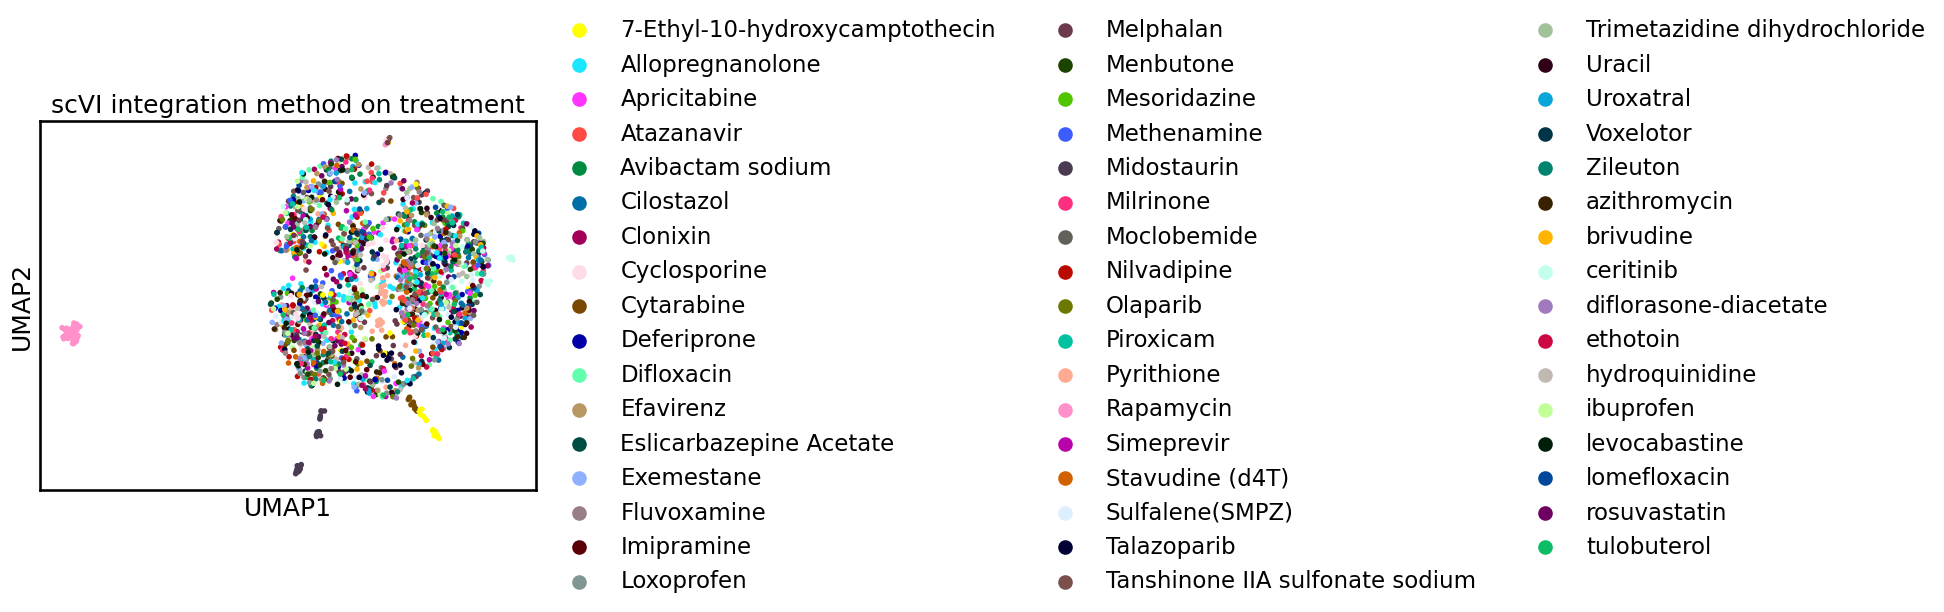

In [24]:
sc.pp.pca(scVI)
sc.pp.neighbors(scVI, n_neighbors=15, use_rep = "X_pca")
sc.tl.umap(scVI)
sc.pl.umap(scVI, color= "treatment", title = "scVI integration method on treatment")

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


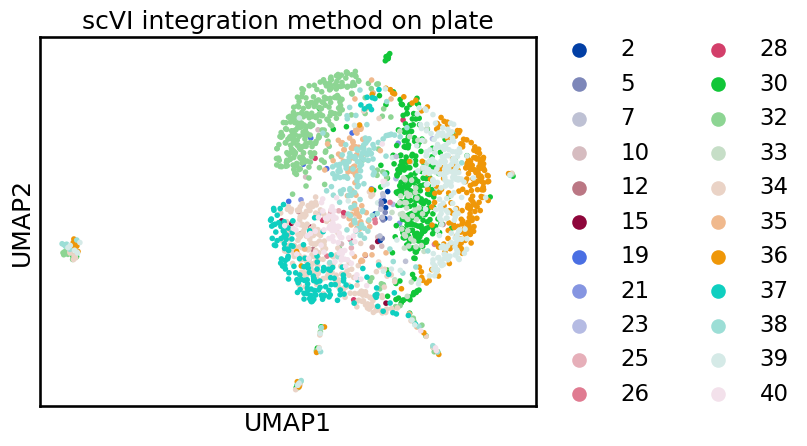

In [23]:
sc.pl.umap(scVI, color= "plate", title = "scVI integration method on plate")

In [25]:
scVI.write_h5ad(
    "rxrx19b_top_50_treatments_scVI.h5ad",
    compression="gzip"
)

### G. scANVI: Compute scIB metrics <a class="anchor" id="after_sub7"></a>

#### i. Batch correction metrics <a class="anchor" id="scIB_sub1"></a>

In [6]:
#Graph connectivity
sc.pp.neighbors(scANVI, n_neighbors=15, use_rep = "X")
scANVI.obs['treatment'] = pd.Categorical(scANVI.obs['treatment'])
gc = scib.me.graph_connectivity(scANVI, label_key="treatment")

In [7]:
#iLISI
ilisi = scib.me.ilisi_graph(scANVI, batch_key="plate", type_="knn")

Chunk 89 does not have enough neighbors. Skipping...
Chunk 179 does not have enough neighbors. Skipping...
Chunk 181 does not have enough neighbors. Skipping...
Chunk 185 does not have enough neighbors. Skipping...
Chunk 348 does not have enough neighbors. Skipping...
Chunk 385 does not have enough neighbors. Skipping...
Chunk 404 does not have enough neighbors. Skipping...
Chunk 410 does not have enough neighbors. Skipping...
Chunk 598 does not have enough neighbors. Skipping...
Chunk 615 does not have enough neighbors. Skipping...
Chunk 621 does not have enough neighbors. Skipping...
Chunk 707 does not have enough neighbors. Skipping...
Chunk 752 does not have enough neighbors. Skipping...
Chunk 781 does not have enough neighbors. Skipping...
Chunk 787 does not have enough neighbors. Skipping...
Chunk 838 does not have enough neighbors. Skipping...
Chunk 874 does not have enough neighbors. Skipping...
Chunk 1050 does not have enough neighbors. Skipping...
Chunk 1093 does not have eno

In [8]:
#principal component regression, computes PCA if not provided: 
pcr_nc = scib.me.pcr(scANVI, covariate="plate")

In [9]:
#silhouette batch 
#only takes a slot in .obsm as input, i.e. embedding or pca -> compute PCA 
sc.pp.pca(scANVI, n_comps = 100)
silhouette_batch = scib.me.silhouette_batch(scANVI, batch_key="plate", label_key="treatment", embed="X_emb")

mean silhouette per group:                                  silhouette_score
group                                            
7-Ethyl-10-hydroxycamptothecin           0.825294
Allopregnanolone                         0.816261
Apricitabine                             0.872416
Atazanavir                               0.829799
Avibactam sodium                         0.869795
Cilostazol                               0.874467
Clonixin                                 0.848410
Cyclosporine                             0.796871
Cytarabine                               0.736693
Deferiprone                              0.827345
Difloxacin                               0.812318
Efavirenz                                0.852384
Eslicarbazepine Acetate                  0.778080
Exemestane                               0.851015
Fluvoxamine                              0.866592
Imipramine                               0.749330
Loxoprofen                               0.821436
Melphalan              

#### ii. Biological conservation metrics <a class="anchor" id="scIB_sub2"></a>

In [10]:
# Convert the column to a categorical variable with string values
scANVI.obs['treatment'] = scANVI.obs['treatment'].astype(str)
scANVI.obs['treatment'] = pd.Categorical(scANVI.obs['treatment'])

# Calculate cLISI graph
clisi = scib.me.clisi_graph(scANVI, label_key="treatment", type_="knn")

Chunk 89 does not have enough neighbors. Skipping...
Chunk 179 does not have enough neighbors. Skipping...
Chunk 181 does not have enough neighbors. Skipping...
Chunk 185 does not have enough neighbors. Skipping...
Chunk 348 does not have enough neighbors. Skipping...
Chunk 385 does not have enough neighbors. Skipping...
Chunk 404 does not have enough neighbors. Skipping...
Chunk 410 does not have enough neighbors. Skipping...
Chunk 598 does not have enough neighbors. Skipping...
Chunk 615 does not have enough neighbors. Skipping...
Chunk 621 does not have enough neighbors. Skipping...
Chunk 707 does not have enough neighbors. Skipping...
Chunk 752 does not have enough neighbors. Skipping...
Chunk 781 does not have enough neighbors. Skipping...
Chunk 787 does not have enough neighbors. Skipping...
Chunk 838 does not have enough neighbors. Skipping...
Chunk 874 does not have enough neighbors. Skipping...
Chunk 1050 does not have enough neighbors. Skipping...
Chunk 1093 does not have eno

In [11]:
#silhouette biological
silhouette = scib.me.silhouette(scANVI, label_key="treatment", embed="X_emb")

In [12]:
#NMI
# cluster_optimal_resolution uses precomputed knn if use_rep == None
nmi = scib.metrics.cluster_optimal_resolution(scANVI, label_key = "treatment",cluster_key = "cluster", metric = scib.me.nmi, return_all = True)[1]

resolution: 0.1, nmi: 0.09106579058996021
resolution: 0.2, nmi: 0.10076946354898504
resolution: 0.3, nmi: 0.10663383935100613
resolution: 0.4, nmi: 0.11226586107160412
resolution: 0.5, nmi: 0.11532153745620324
resolution: 0.6, nmi: 0.11703419088305393
resolution: 0.7, nmi: 0.12602336669625705
resolution: 0.8, nmi: 0.13141669792469438
resolution: 0.9, nmi: 0.1345227613905851
resolution: 1.0, nmi: 0.13911657465863275
resolution: 1.1, nmi: 0.14762023981226186
resolution: 1.2, nmi: 0.15559206845287504
resolution: 1.3, nmi: 0.15810627774780936
resolution: 1.4, nmi: 0.16067051717718953
resolution: 1.5, nmi: 0.17054254154872517
resolution: 1.6, nmi: 0.17399314673545022
resolution: 1.7, nmi: 0.17452827916083397
resolution: 1.8, nmi: 0.17365061298477807
resolution: 1.9, nmi: 0.1780579561402976
resolution: 2.0, nmi: 0.18030361876399978
optimised clustering against treatment
optimal cluster resolution: 2.0
optimal score: 0.18030361876399978


In [13]:
#ARI
# cluster_optimal_resolution uses precomputed knn if use_rep == None
ari = scib.metrics.cluster_optimal_resolution(scANVI, label_key = "treatment",cluster_key = "cluster", metric = scib.me.ari, return_all = True)[1]

resolution: 0.1, ari: 0.002566634265887863
resolution: 0.2, ari: 0.00593637191691645
resolution: 0.3, ari: 0.006582021752506147
resolution: 0.4, ari: 0.007406776404745686
resolution: 0.5, ari: 0.010524290315607943
resolution: 0.6, ari: 0.010087681311372974
resolution: 0.7, ari: 0.012103348958580777
resolution: 0.8, ari: 0.012655300720908584
resolution: 0.9, ari: 0.014029652322764395
resolution: 1.0, ari: 0.01670063587739548
resolution: 1.1, ari: 0.01815318784434771
resolution: 1.2, ari: 0.020909503625808408
resolution: 1.3, ari: 0.01962175127632188
resolution: 1.4, ari: 0.02194158567492337
resolution: 1.5, ari: 0.023377640014240225
resolution: 1.6, ari: 0.023130694131428365
resolution: 1.7, ari: 0.02405934096354463
resolution: 1.8, ari: 0.0240197512627408
resolution: 1.9, ari: 0.02414662954583897
resolution: 2.0, ari: 0.02580364836471321
optimised clustering against treatment
optimal cluster resolution: 2.0
optimal score: 0.02580364836471321


In [14]:
#Isolated label score F1
isolated_label_F1 = scib.me.isolated_labels_f1(scANVI, batch_key="plate", label_key="treatment", embed = "X_emb")

isolated labels: no more than 6 batches per label
Compute neighbors on rep X_emb
7-Ethyl-10-hydroxycamptothecin: 0.6
Compute neighbors on rep X_emb
Apricitabine: 0.08888888888888888
Compute neighbors on rep X_emb
Atazanavir: 0.11363636363636365
Compute neighbors on rep X_emb
Avibactam sodium: 0.1038961038961039
Compute neighbors on rep X_emb
Cilostazol: 0.07207207207207207
Compute neighbors on rep X_emb
Clonixin: 0.0916030534351145
Compute neighbors on rep X_emb
Cyclosporine: 0.1678321678321678
Compute neighbors on rep X_emb
Cytarabine: 0.3407407407407408
Compute neighbors on rep X_emb
Deferiprone: 0.0975609756097561
Compute neighbors on rep X_emb
Difloxacin: 0.10687022900763359
Compute neighbors on rep X_emb
Efavirenz: 0.07518796992481203
Compute neighbors on rep X_emb
Eslicarbazepine Acetate: 0.08080808080808081
Compute neighbors on rep X_emb
Exemestane: 0.07920792079207921
Compute neighbors on rep X_emb
Fluvoxamine: 0.10666666666666666
Compute neighbors on rep X_emb
Imipramine: 0.12

In [15]:
#Isolated label score ASW
isolated_label_ASW = scib.me.isolated_labels_asw(scANVI, batch_key="plate", label_key="treatment", embed="X_emb")

isolated labels: no more than 6 batches per label
7-Ethyl-10-hydroxycamptothecin: 0.3785929009318352
Apricitabine: 0.456086128950119
Atazanavir: 0.4499079994857311
Avibactam sodium: 0.4440590888261795
Cilostazol: 0.4400806687772274
Clonixin: 0.4557088166475296
Cyclosporine: 0.3891690969467163
Cytarabine: 0.3059300035238266
Deferiprone: 0.4741838648915291
Difloxacin: 0.4515688754618168
Efavirenz: 0.42902811616659164
Eslicarbazepine Acetate: 0.4482791870832443
Exemestane: 0.41775888949632645
Fluvoxamine: 0.48461223114281893
Imipramine: 0.37024208903312683
Loxoprofen: 0.4072311073541641
Melphalan: 0.32703687250614166
Menbutone: 0.4480818882584572
Mesoridazine: 0.4525236561894417
Methenamine: 0.35500338673591614
Midostaurin: 0.6317127346992493
Milrinone: 0.43185142427682877
Moclobemide: 0.4524654634296894
Nilvadipine: 0.42230329662561417
Olaparib: 0.44591162726283073
Piroxicam: 0.42309390008449554
Pyrithione: 0.4212273210287094
Rapamycin: 0.8818210363388062
Simeprevir: 0.4430037923157215
S

#### iii. Have a look at result <a class="anchor" id="scIB_sub3"></a>
Unintegrated results

1. Batch correction metrics

In [16]:
scANVI_metrics = pd.DataFrame({"scANVI: Batch correction metrics": []})

scANVI_metrics.loc["Graph_Conn"] = gc
scANVI_metrics.loc["iLISI"] = ilisi
scANVI_metrics.loc["PCR_NC"] = pcr_nc
scANVI_metrics.loc["PCR_Comparison"] = None
scANVI_metrics.loc["Silhouette_batch"] = silhouette_batch

scANVI_metrics

,scANVI: Batch correction metrics
Graph_Conn,0.212778
iLISI,0.088234
PCR_NC,0.162401
PCR_Comparison,NaN
Silhouette_batch,0.827564


2. Biological conservation metrics

In [17]:
scANVI_metrics_1 = pd.DataFrame({"scANVI: biol. conservation metrics": []})

scANVI_metrics_1.loc["cLISI"] = clisi
scANVI_metrics_1.loc["Silhouette"] = silhouette
scANVI_metrics_1.loc["NMI"] = nmi
scANVI_metrics_1.loc["ARI"] = ari
scANVI_metrics_1.loc["Isolated_label_F1"] = isolated_label_F1
scANVI_metrics_1.loc["Isolated_label_ASW"] = isolated_label_ASW

scANVI_metrics_1

,scANVI: biol. conservation metrics
cLISI,0.798332
Silhouette,0.446662
NMI,0.180304
ARI,0.025804
Isolated_label_F1,0.171286
Isolated_label_ASW,0.447364


### H. scANVI: Before and after UMAP visualization <a class="anchor" id="after_sub8"></a>

<b> After scANVI integration: <b>

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


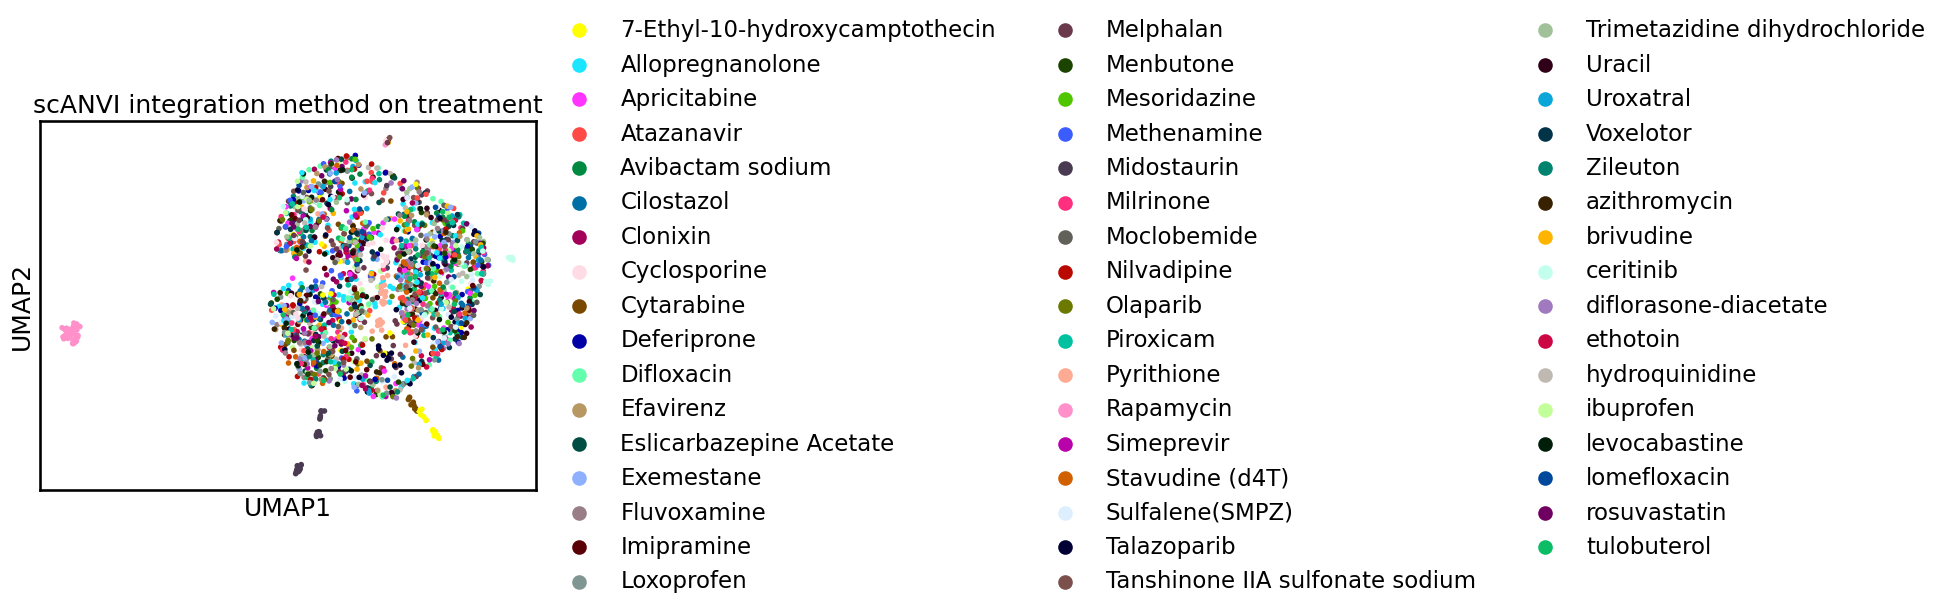

In [21]:
sc.pp.pca(scANVI)
sc.pp.neighbors(scANVI, n_neighbors=15, use_rep = "X_pca")
sc.tl.umap(scANVI)
sc.pl.umap(scANVI, color= "treatment", title = "scANVI integration method on treatment")

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


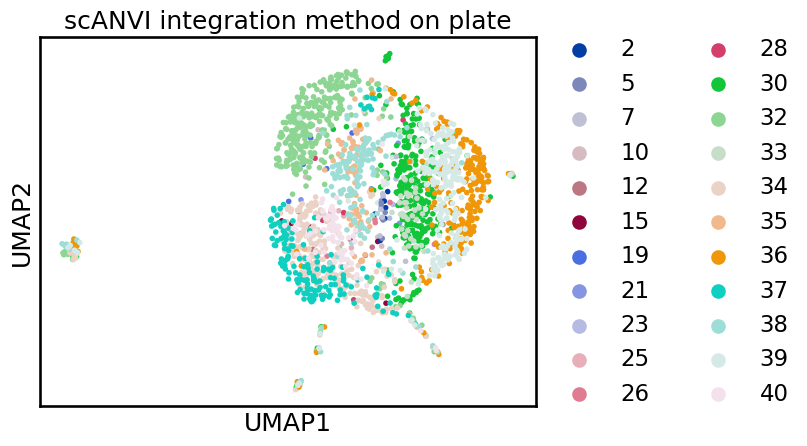

In [19]:
sc.pl.umap(scANVI, color= "plate", title = "scANVI integration method on plate")

In [20]:
scANVI.write_h5ad(
    "rxrx19b_top_50_treatments_scANVI.h5ad",
    compression="gzip"
)

### I. scGen: Compute scIB metrics <a class="anchor" id="after_sub9"></a>

#### i. Batch correction metrics <a class="anchor" id="scIB_sub1"></a>

In [9]:
#Graph connectivity
sc.pp.neighbors(scGen, n_neighbors=15, use_rep = "X")
scGen.obs['treatment'] = pd.Categorical(scGen.obs['treatment'])
gc = scib.me.graph_connectivity(scGen, label_key="treatment")

In [10]:
#iLISI
ilisi = scib.me.ilisi_graph(scGen, batch_key="plate", type_="knn")

In [11]:
#principal component regression, computes PCA if not provided: 
pcr_nc = scib.me.pcr(scGen, covariate="plate")

In [13]:
#silhouette batch 
#only takes a slot in .obsm as input, i.e. embedding or pca -> compute PCA 
sc.pp.pca(scGen, n_comps = 100)
silhouette_batch = scib.me.silhouette_batch(scGen, batch_key="plate", label_key="treatment", embed="corrected_latent")

mean silhouette per group:                                  silhouette_score
group                                            
7-Ethyl-10-hydroxycamptothecin           0.848740
Allopregnanolone                         0.844358
Apricitabine                             0.867063
Atazanavir                               0.871611
Avibactam sodium                         0.882564
Cilostazol                               0.859159
Clonixin                                 0.882284
Cyclosporine                             0.849339
Cytarabine                               0.858758
Deferiprone                              0.868227
Difloxacin                               0.882544
Efavirenz                                0.869337
Eslicarbazepine Acetate                  0.873478
Exemestane                               0.893345
Fluvoxamine                              0.853743
Imipramine                               0.821985
Loxoprofen                               0.852058
Melphalan              

#### ii. Biological conservation metrics <a class="anchor" id="scIB_sub2"></a>

In [14]:
# Convert the column to a categorical variable with string values
scGen.obs['treatment'] = scGen.obs['treatment'].astype(str)
scGen.obs['treatment'] = pd.Categorical(scGen.obs['treatment'])

# Calculate cLISI graph
clisi = scib.me.clisi_graph(scGen, label_key="treatment", type_="knn")

In [15]:
#silhouette biological
silhouette = scib.me.silhouette(scGen, label_key="treatment", embed="corrected_latent")

In [16]:
#NMI
# cluster_optimal_resolution uses precomputed knn if use_rep == None
nmi = scib.metrics.cluster_optimal_resolution(scGen, label_key = "treatment",cluster_key = "cluster", metric = scib.me.nmi, return_all = True)[1]

resolution: 0.1, nmi: 0.12255029910499285
resolution: 0.2, nmi: 0.14443081809299965
resolution: 0.3, nmi: 0.19940601598605737
resolution: 0.4, nmi: 0.2061396473952902
resolution: 0.5, nmi: 0.22210099579397588
resolution: 0.6, nmi: 0.22389655824029048
resolution: 0.7, nmi: 0.23143797585111062
resolution: 0.8, nmi: 0.2402813851586668
resolution: 0.9, nmi: 0.2270613301809177
resolution: 1.0, nmi: 0.2521572619137547
resolution: 1.1, nmi: 0.258209003621153
resolution: 1.2, nmi: 0.2598600370174852
resolution: 1.3, nmi: 0.2633716887705441
resolution: 1.4, nmi: 0.26628836392444843
resolution: 1.5, nmi: 0.2756078454554683
resolution: 1.6, nmi: 0.2768590193831953
resolution: 1.7, nmi: 0.29108895459869455
resolution: 1.8, nmi: 0.2828800516112395
resolution: 1.9, nmi: 0.28683452441839297
resolution: 2.0, nmi: 0.2903645652126581
optimised clustering against treatment
optimal cluster resolution: 1.7
optimal score: 0.29108895459869455


In [17]:
#ARI
# cluster_optimal_resolution uses precomputed knn if use_rep == None
ari = scib.metrics.cluster_optimal_resolution(scGen, label_key = "treatment",cluster_key = "cluster", metric = scib.me.ari, return_all = True)[1]

resolution: 0.1, ari: 0.004638540762494716
resolution: 0.2, ari: 0.006852774822992872
resolution: 0.3, ari: 0.017008795085523935
resolution: 0.4, ari: 0.019632034838957844
resolution: 0.5, ari: 0.03134543762944787
resolution: 0.6, ari: 0.03367016910094255
resolution: 0.7, ari: 0.0383817322760684
resolution: 0.8, ari: 0.05108027855763905
resolution: 0.9, ari: 0.04333987626461525
resolution: 1.0, ari: 0.059938465453879784
resolution: 1.1, ari: 0.06513958668091596
resolution: 1.2, ari: 0.0662860661488053
resolution: 1.3, ari: 0.07062599278280014
resolution: 1.4, ari: 0.07208175881294293
resolution: 1.5, ari: 0.0763617004787025
resolution: 1.6, ari: 0.07837990555464014
resolution: 1.7, ari: 0.08562921423595823
resolution: 1.8, ari: 0.08325227389732916
resolution: 1.9, ari: 0.0872209798171801
resolution: 2.0, ari: 0.08999946104513376
optimised clustering against treatment
optimal cluster resolution: 2.0
optimal score: 0.08999946104513376


In [18]:
#Isolated label score F1
isolated_label_F1 = scib.me.isolated_labels_f1(scGen, batch_key="plate", label_key="treatment", embed = "corrected_latent")

isolated labels: no more than 6 batches per label
Compute neighbors on rep corrected_latent
7-Ethyl-10-hydroxycamptothecin: 0.5
Compute neighbors on rep corrected_latent
Apricitabine: 0.13071895424836602
Compute neighbors on rep corrected_latent
Atazanavir: 0.11881188118811883
Compute neighbors on rep corrected_latent
Avibactam sodium: 0.1290322580645161
Compute neighbors on rep corrected_latent
Cilostazol: 0.08771929824561403
Compute neighbors on rep corrected_latent
Clonixin: 0.14084507042253522
Compute neighbors on rep corrected_latent
Cyclosporine: 0.32558139534883723
Compute neighbors on rep corrected_latent
Cytarabine: 0.3125
Compute neighbors on rep corrected_latent
Deferiprone: 0.12698412698412698
Compute neighbors on rep corrected_latent
Difloxacin: 0.24561403508771928
Compute neighbors on rep corrected_latent
Efavirenz: 0.08888888888888888
Compute neighbors on rep corrected_latent
Eslicarbazepine Acetate: 0.16438356164383564
Compute neighbors on rep corrected_latent
Exemestan

In [19]:
#Isolated label score ASW
isolated_label_ASW = scib.me.isolated_labels_asw(scGen, batch_key="plate", label_key="treatment", embed="corrected_latent")

isolated labels: no more than 6 batches per label
7-Ethyl-10-hydroxycamptothecin: 0.43542513251304626
Apricitabine: 0.47796113044023514
Atazanavir: 0.4529029466211796
Avibactam sodium: 0.4714119005948305
Cilostazol: 0.43947217240929604
Clonixin: 0.47753074020147324
Cyclosporine: 0.42791598290205
Cytarabine: 0.4620455875992775
Deferiprone: 0.45408201217651367
Difloxacin: 0.49613022711127996
Efavirenz: 0.4468810334801674
Eslicarbazepine Acetate: 0.4596145302057266
Exemestane: 0.46289538592100143
Fluvoxamine: 0.4870795253664255
Imipramine: 0.46091292425990105
Loxoprofen: 0.4557705745100975
Melphalan: 0.4243589788675308
Menbutone: 0.4662494696676731
Mesoridazine: 0.47783542796969414
Methenamine: 0.4518050141632557
Midostaurin: 0.4633396789431572
Milrinone: 0.47350370697677135
Moclobemide: 0.4481717273592949
Nilvadipine: 0.4624827839434147
Olaparib: 0.4646022245287895
Piroxicam: 0.45549313351511955
Pyrithione: 0.5476332120597363
Rapamycin: 0.7328055948019028
Simeprevir: 0.4803303424268961
S

#### iii. Have a look at result <a class="anchor" id="scIB_sub3"></a>
Unintegrated results

1. Batch correction metrics

In [20]:
scGen_metrics = pd.DataFrame({"scGen: Batch correction metrics": []})

scGen_metrics.loc["Graph_Conn"] = gc
scGen_metrics.loc["iLISI"] = ilisi
scGen_metrics.loc["PCR_NC"] = pcr_nc
scGen_metrics.loc["PCR_Comparison"] = None
scGen_metrics.loc["Silhouette_batch"] = silhouette_batch

scGen_metrics

,scGen: Batch correction metrics
Graph_Conn,0.454722
iLISI,0.220451
PCR_NC,0.024476
PCR_Comparison,NaN
Silhouette_batch,0.867301


2. Biological conservation metrics

In [21]:
scGen_metrics_1 = pd.DataFrame({"scGen: biol. conservation metrics": []})

scGen_metrics_1.loc["cLISI"] = clisi
scGen_metrics_1.loc["Silhouette"] = silhouette
scGen_metrics_1.loc["NMI"] = nmi
scGen_metrics_1.loc["ARI"] = ari
scGen_metrics_1.loc["Isolated_label_F1"] = isolated_label_F1
scGen_metrics_1.loc["Isolated_label_ASW"] = isolated_label_ASW

scGen_metrics_1

,scGen: biol. conservation metrics
cLISI,0.823828
Silhouette,0.473532
NMI,0.291089
ARI,0.089999
Isolated_label_F1,0.214081
Isolated_label_ASW,0.471288


### J. scGen: Before and after UMAP visualization <a class="anchor" id="after_sub10"></a>

<b> After scGen integration: <b>

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


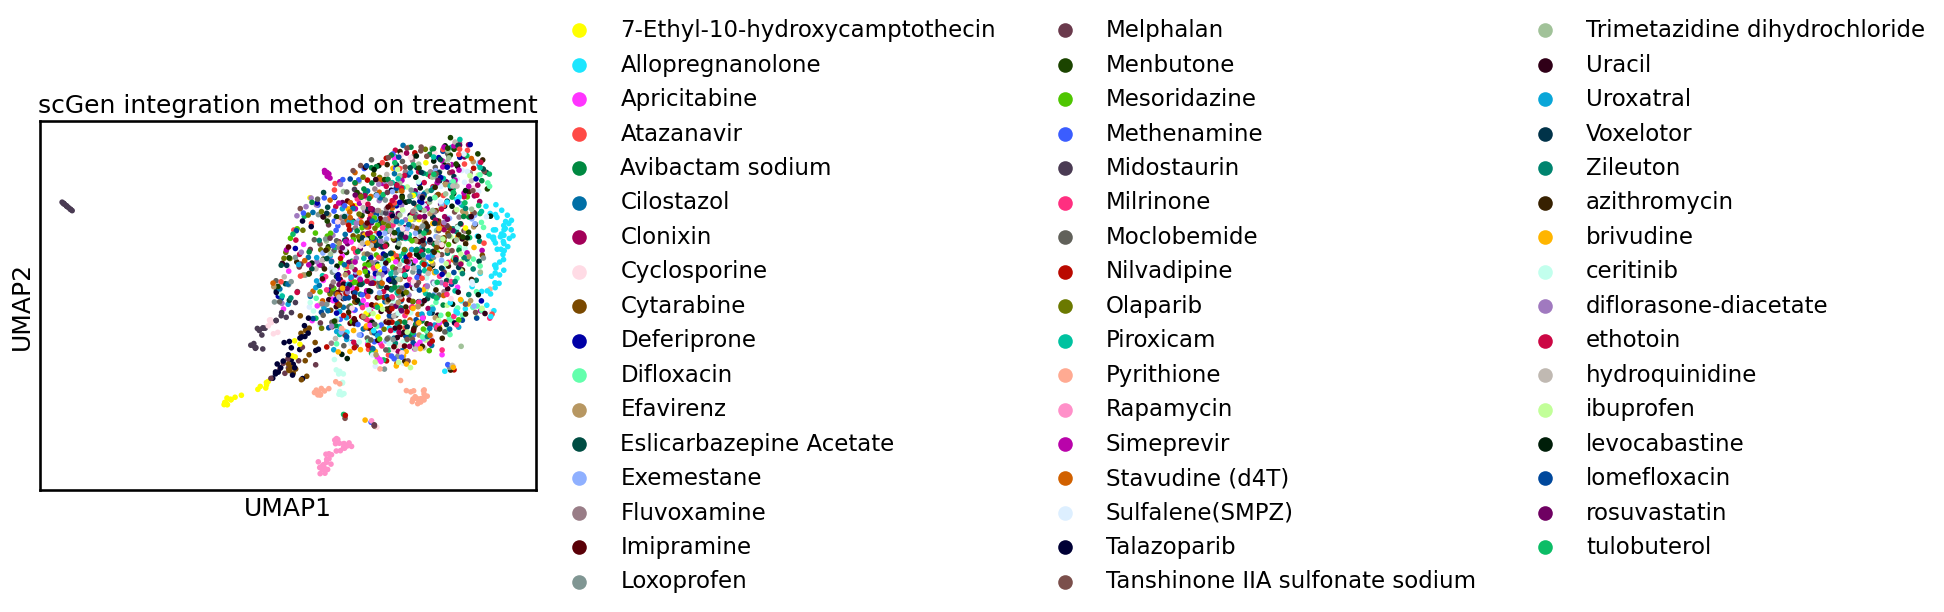

In [29]:
sc.pp.pca(scGen)
sc.pp.neighbors(scGen, n_neighbors=15, use_rep = "corrected_latent")
sc.tl.umap(scGen)
sc.pl.umap(scGen, color= "treatment", title = "scGen integration method on treatment")

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


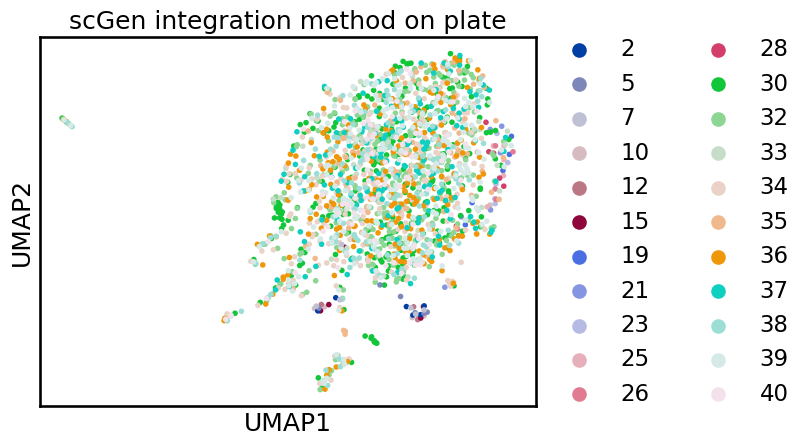

In [30]:
sc.pl.umap(scGen, color= "plate", title = "scGen integration method on plate")

We realize that scGen performs very well regarding removing "plate" as batch effect while preserving biology "treatment".

In [31]:
scGen.write_h5ad(
    "rxrx19b_top_50_treatments_scGen.h5ad",
    compression="gzip"
)